In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import sys 
import numpy.ma as ma
import scipy.stats as st
import scipy.signal as si
from astropy.io import fits
from astropy.table import Table
import scipy.ndimage.morphology as morph
from matplotlib.backends.backend_pdf import PdfPages


sys.path.insert(0,'../lib')

import detection_tools as dt
import detection_preprocessing as dp
import strategy_detection_pose as sdp
import mle_sparse_est as mse
import parameters

import strategy_detection_pose as sd

%matplotlib inline
%load_ext autoreload

In [2]:
sys.path.insert(0,'../MPDAF')
import mpdaf

from mpdaf.obj import WCS
from mpdaf.obj import WaveCoord
from mpdaf.obj import Image
from mpdaf.obj import Spectrum
from mpdaf.obj import Cube
from mpdaf.obj import CubeDisk

from mpdaf.sdetect import Source, SourceList

In [3]:
# Version information
version = 1.4
# source dir
nom_dossier='../results/sources/'

In [4]:
def calcul_fwhm(lam):
    """
    Full-Width at Half Maximum computation for the HDFS datacube.
    See Bacon et al., 2015, *The MUSE 3D View of the Hubble Deep Field South*.
    
    :param float lam: wavelength to perform the computation.
    
    """
    return -1.625*10**(-4) *lam + 4.5375

In [5]:
cube = Cube('../data/DATACUBE-HDFS-v1.24.fits')

cat_fits = fits.open('../data/Catalog_HDFS_v1p0.fits',memmap=True)

In [6]:
cube.shape

array([3641,  331,  326])

In [7]:
# Truncating cube (ignoring borders)
range_cube = cube.get_range()

range_cube[0,1] = cube.wcs.pix2sky([5,5])[0][0]
range_cube[1,1] = cube.wcs.pix2sky([320,320])[0][0]
range_cube[0,2] = cube.wcs.pix2sky([320,320])[0][1]
range_cube[1,2] = cube.wcs.pix2sky([5,5])[0][1]

print cube.get_range()
print range_cube

cube = cube.truncate(range_cube)

[[ 4750.           -60.57281074   338.21299923]
 [ 9300.           -60.55443269   338.24976125]]
[[ 4750.           -60.5724726    338.21356531]
 [ 9300.           -60.55504849   338.24919539]]


In [8]:
#Creating source list + files
tbdata = cat_fits[1].data
z = tbdata['Z']
tout = tbdata
coords = np.array([tout['X'], tout['Y'], tout['Z']])

num = tout['ID']
categ = tout['CATEGORY']

# Now we keep only lyman-alpha emitters, labeled as 'Lya' in the catalog
cat_lya = tout[(categ=='Lya')&(z>=0)]
coords_lya = np.array([cat_lya['X'], cat_lya['Y'], cat_lya['Z']])

ra_lya = cat_lya['RA']
dec_lya = cat_lya['DEC']
z_lya = cat_lya['Z']

#coords_lya[2,:] = ((1 + coords_lya[2,:])*lambda_lya - lambda_0)/pas_spectral

coords_lya = coords_lya.astype(int)
num_lya = num[(categ=='Lya')&(z>=0)]

In [9]:
    LAMBDA_LINES = {
    43: {'lambda':[5212., 5230.],'fwhm':0.74},
    92: {'lambda':[6778., 6800.],'fwhm':0.675},
    95: {'lambda':[6344., 6359.],'fwhm':0.695},
    112: {'lambda':[5963., 5975.],'fwhm':0.72},
    139: {'lambda':[5275., 5297.],'fwhm':0.73},
    159: {'lambda':[5764., 5775.],'fwhm':0.725},
    162: {'lambda':[5196., 5213.],'fwhm':0.74},
    181: {'lambda':[5269., 5280.],'fwhm':0.735},
    200: {'lambda':[5285., 5294.],'fwhm':0.735},
    216: {'lambda':[6092., 6115.],'fwhm':0.71},
    232: {'lambda':[7553, 7564],'fwhm':0.645},
    246: {'lambda':[8116., 8132.],'fwhm':0.635},
    257: {'lambda':[6715., 6726.],'fwhm':0.725},
    290: {'lambda':[8611., 8623.],'fwhm':0.62},
    294: {'lambda':[6067., 6078.],'fwhm':0.71},
    308: {'lambda':[6096., 6111.],'fwhm':0.71},
    311: {'lambda':[5941., 5951.],'fwhm':0.72},
    324: {'lambda':[5471., 5479.],'fwhm':0.73},
    325: {'lambda':[6927., 6940.],'fwhm':0.665},
    334: {'lambda':[7188., 7198.],'fwhm':0.66},
    338: {'lambda':[7170., 7181.],'fwhm':0.66},
    393: {'lambda':[6305., 6316.],'fwhm':0.695},
    422: {'lambda':[5016., 5025.],'fwhm':0.75},
    430: {'lambda':[8849., 8862.],'fwhm':0.61},
    437: {'lambda':[5005., 5015.],'fwhm':0.75},
    449: {'lambda':[5196., 5205.],'fwhm':0.74},
    469: {'lambda':[5427., 5437.],'fwhm':0.73},
    484: {'lambda':[7185., 7196.],'fwhm':0.66},
    489: {'lambda':[4806., 4819.],'fwhm':0.76},
    500: {'lambda':[5470., 5480.],'fwhm':0.73},
    503: {'lambda':[5284., 5295.],'fwhm':0.73},
    514: {'lambda':[5861., 5873.],'fwhm':0.725},
    520: {'lambda':[5441., 5451.],'fwhm':0.73},
    543: {'lambda':[5628., 5639.],'fwhm':0.725},
    546: {'lambda':[8157., 8174.],'fwhm':0.635},
    547: {'lambda':[8157., 8170.],'fwhm':0.635},
    549: {'lambda':[6895., 6905.],'fwhm':0.665},
    551: {'lambda':[5079., 5089.],'fwhm':0.75},
    553: {'lambda':[7388., 7401.],'fwhm':0.655},
    558: {'lambda':[5015., 5025.],'fwhm':0.75},
    563: {'lambda':[5865., 5876.],'fwhm':0.725},
    568: {'lambda':[6880., 6894.],'fwhm':0.67},
    574: {'lambda':[8158., 8168.],'fwhm':0.635},
    579: {'lambda':[5595., 5604.],'fwhm':0.68},
    580: {'lambda':[5631., 5640.],'fwhm':0.725},
    583: {'lambda':[7187., 7195.],'fwhm':0.66},
    56: {'lambda':[4871., 4890.],'fwhm':0.76},
    40: {'lambda':[4872., 4887.],'fwhm':0.76},
    71: {'lambda': [4961.6, 4973.7],'fwhm':0.76},
    89: {'lambda': [6089.5, 6110.2],'fwhm':0.76},
    119: {'lambda': [4992.0, 4999],'fwhm':0.76},
    121: {'lambda': [5474.1, 5480.5],'fwhm':0.76},
    144: {'lambda': [6092, 6110.0],'fwhm':0.71},
    146: {'lambda': [5826, 5837],'fwhm':0.72},
    155: {'lambda': [4883.0, 4888.0],'fwhm':0.76},
    183: {'lambda': [5314.6, 5325.2],'fwhm':0.73},
    186: {'lambda': [7170.0, 7185],'fwhm':0.66},
    202: {'lambda': [5197., 5209.4],'fwhm':0.73},
    218: {'lambda': [7169.1, 7183.2],'fwhm':0.66},
    225: {'lambda': [6454.4, 6466.3],'fwhm':0.695},
    238: {'lambda': [5860.1, 5861.8],'fwhm':0.72},
    261: {'lambda': [5314.4, 5325.0],'fwhm':0.76},
    271: {'lambda': [6308.0, 6318.],'fwhm':0.695},
    363: {'lambda': [6717.0, 6730.5],'fwhm':0.725},
    386: {'lambda': [5761.9, 5769.2],'fwhm':0.72},
    433: {'lambda': [5431.1, 5440.0],'fwhm':0.76},
    441: {'lambda': [6919.5, 6933.1],'fwhm':0.665},
    452: {'lambda': [5005.6, 5015.7],'fwhm':0.75},
    453: {'lambda': [6930.0, 6939.8],'fwhm':0.665},
    462: {'lambda': [8016., 8026.],'fwhm':0.64},
    474: {'lambda': [6937.3, 6956.1],'fwhm':0.665},
    478: {'lambda': [5429.9, 5440.0],'fwhm':0.76},
    492: {'lambda': [8216.0, 8228.1],'fwhm':0.635},
    498: {'lambda': [6326.0, 6338.5],'fwhm':0.695},
    499: {'lambda': [6921., 6934.4],'fwhm':0.665},
    501: {'lambda': [5014.0, 5026.2],'fwhm':0.75},
    513: {'lambda': [5198, 5209],'fwhm':0.74},
    534: {'lambda': [6599.0, 6615],'fwhm':0.7},
    548: {'lambda': [6914, 6923],'fwhm':0.665},
    550: {'lambda': [6882, 6890.3],'fwhm':0.665},
    552: {'lambda': [7392, 7402.1],'fwhm':0.66},
    555: {'lambda': [6693, 6709],'fwhm':0.665},
    557: {'lambda': [7539., 7550.0],'fwhm':0.645},
    559: {'lambda': [7152.6, 7159.6],'fwhm':0.66},
    560: {'lambda': [8359.6, 8370.0],'fwhm':0.64},
    561: {'lambda': [7060.2, 7072.8],'fwhm':0.66},
    562: {'lambda': [7101.0, 7110.2],'fwhm':0.66},
    564: {'lambda': [8607.3, 8622.0],'fwhm':0.62},
    573: {'lambda': [8838.2, 8848.6],'fwhm':0.62},
    575: {'lambda': [8673., 8684.],'fwhm':0.62},
    577: {'lambda': [8215.6, 8228.3],'fwhm':0.62},
    578: {'lambda': [5078.7, 5088.3],'fwhm':0.75},
    581: {'lambda': [5860., 5879.],'fwhm':0.72},
    582: {'lambda': [6797.8, 6808.8],'fwhm':0.725},
    584: {'lambda': [8377, 8389],'fwhm':0.64},
    585: {'lambda': [5271.9, 5280.2],'fwhm':0.74},
    586: {'lambda': [7414, 7428],'fwhm':0.66},
    587: {'lambda': [6606.7, 6616.0],'fwhm':0.665},
    }

In [10]:

src_list = SourceList.from_path(nom_dossier)

In [11]:
# pour avoir les numeros des objets ( methode depuis l'objet SourceList ?)
nb_obj = 0
for s in src_list:
    nb_obj+=1
num_src = np.zeros(shape=(nb_obj))
i=0
for s in src_list:
    if s.id==554:
        continue
        
    num_src[i] = s.id
    i+=1
print num_src
num_src_sort = np.copy(num_src)
num_src_sort.sort()

print num_src_sort

[ 563.  498.  578.  225.  393.  580.  547.  562.  560.  232.   95.  557.
  162.  139.  159.  246.  202.  574.   43.  568.  489.   71.  452.  311.
  503.  216.  324.  430.  581.  186.  469.  474.  441.  484.  144.  558.
  500.  520.  146.  534.  238.  559.  577.  462.  290.  449.  334.  564.
  561.  181.  386.  553.  478.  325.  183.   89.  543.  271.  437.  548.
  200.   40.  552.  513.  555.  583.  492.  433.  308.  422.  218.  573.
  549.  499.  261.  294.  551.  112.  514.   92.  257.  546.  584.  363.
  155.  585.  338.  453.]
[  40.   43.   71.   89.   92.   95.  112.  139.  144.  146.  155.  159.
  162.  181.  183.  186.  200.  202.  216.  218.  225.  232.  238.  246.
  257.  261.  271.  290.  294.  308.  311.  324.  325.  334.  338.  363.
  386.  393.  422.  430.  433.  437.  441.  449.  452.  453.  462.  469.
  474.  478.  484.  489.  492.  498.  499.  500.  503.  513.  514.  520.
  534.  543.  546.  547.  548.  549.  551.  552.  553.  555.  557.  558.
  559.  560.  561.  562. 

In [12]:
lambda_0 = 4750    # see Bacon et al, 2015
lambda_lya = 1216
pas_spectral = 1.25 # Angstrom / spectral band

W = 20
W_aff = 300
S = 50

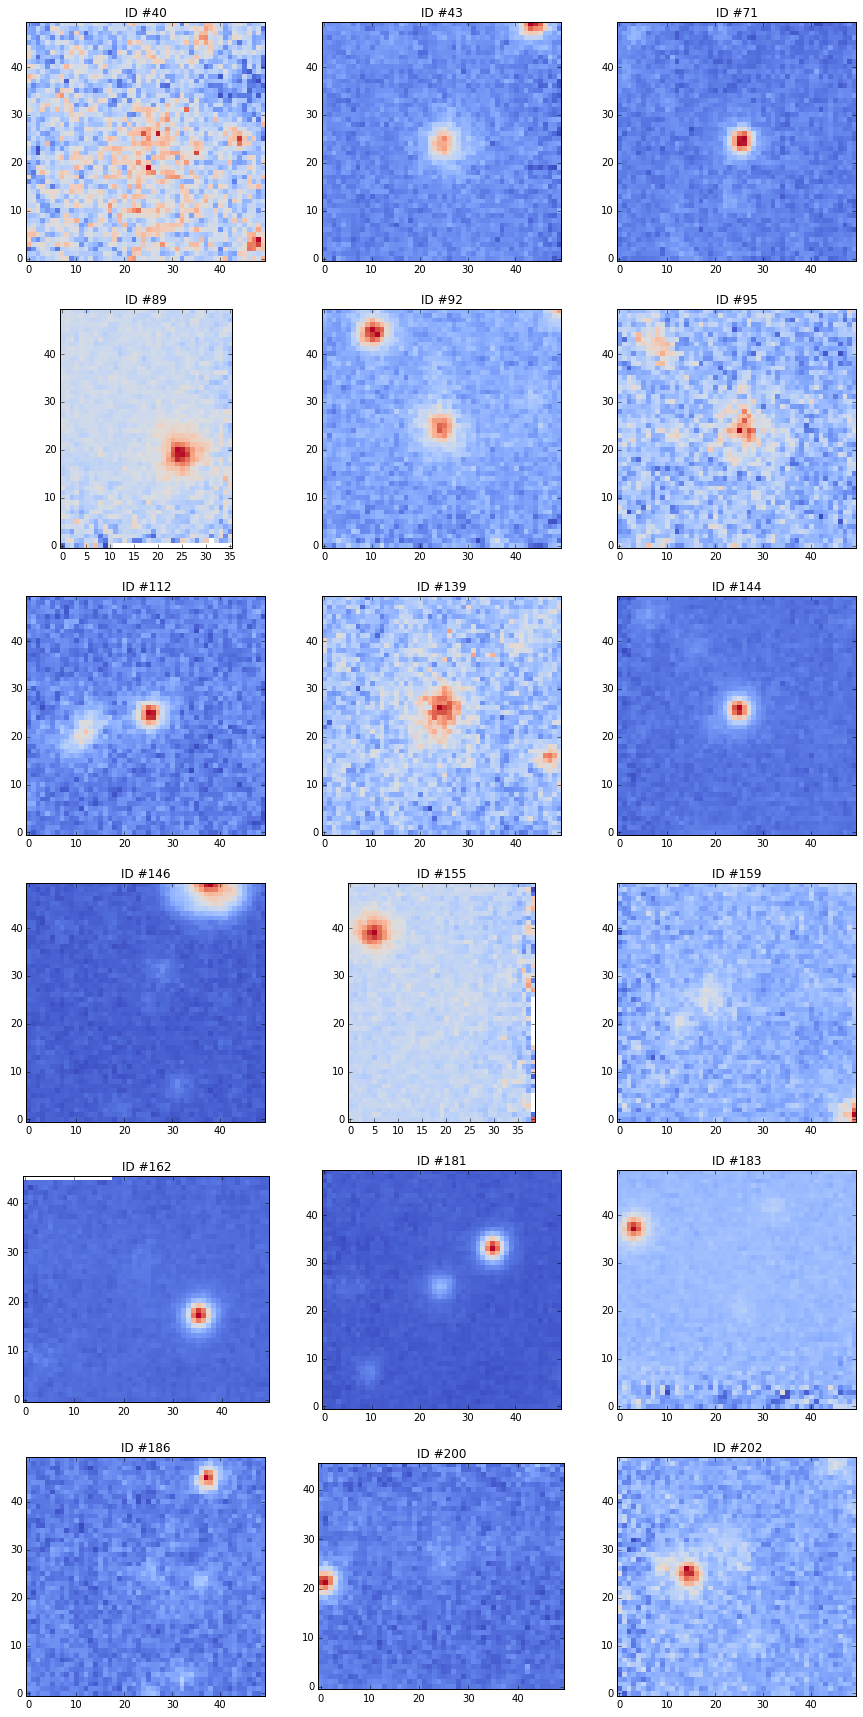

In [13]:
i = 0
nb_li=6
plt.figure(figsize=(3*5,nb_li*5))
for num_obj in range(num_src.size):

    if num_obj > 17:
        continue

    src = src_list[np.where(num_src==num_src_sort[num_obj])[0]]
    
    lam_ang = src.lines['lya_start'][0] +  0.5*(src.lines['lya_end'][0] - src.lines['lya_start'][0])

    deb_lar = lam_ang - W_aff/2 * pas_spectral
    if deb_lar < lambda_0: deb_lar = lambda_0 +1
    fin_lar = deb_lar+W_aff*pas_spectral
    
    
    #sp_range_large = np.arange(deb_lar,fin_lar+1,pas_spectral)
    #sub_cube_large = cube.subcube((src.dec,src.ra),S,lbda=(deb_lar,fin_lar),pix=True)
    
    deb = lam_ang - W/2*pas_spectral
    if deb < lambda_0: deb = lambda_0 + 1
    fin = deb+W*pas_spectral
    sub_cube_tight = cube.subcube((src.dec,src.ra),S,lbda=(deb,fin),pix=True)
    

    ax = plt.subplot(nb_li,3,i+1)
    im = sub_cube_tight.sum(axis=0)
    im_np = im.get_np_data()
    plt.imshow(im_np,origin='lower',cmap=plt.cm.coolwarm,interpolation='nearest')
    #im.plot(plt.cm.coolwarm)
    plt.title('ID #'+str(src.id))
    #ax.set
    i+=1

/home/miv/courbot/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:12: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/home/miv/courbot/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:152: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
[INFO] Computing image for lbda 4751.25-5126.25 [0-300]
INFO:mpdaf corelib:Computing image for lbda 4751.25-5126.25 [0-300]
[INFO] Computing image for lbda 4872-4887 [97-108]
INFO:mpdaf corelib:Computing image for lbda 4872-4887 [97-108]


40
43

[INFO] Computing image for lbda 5033.75-5408.75 [0-300]
INFO:mpdaf corelib:Computing image for lbda 5033.75-5408.75 [0-300]
[INFO] Computing image for lbda 5212-5230 [143-157]
INFO:mpdaf corelib:Computing image for lbda 5212-5230 [143-157]
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified



71

[INFO] Computing image for lbda 4780-5155 [0-300]
INFO:mpdaf corelib:Computing image for lbda 4780-5155 [0-300]
[INFO] Computing image for lbda 4961.6-4973.7 [146-154]
INFO:mpdaf corelib:Computing image for lbda 4961.6-4973.7 [146-154]



89

[INFO] Computing image for lbda 5912.5-6287.5 [0-300]
INFO:mpdaf corelib:Computing image for lbda 5912.5-6287.5 [0-300]
[INFO] Computing image for lbda 6089.5-6110.2 [142-158]
INFO:mpdaf corelib:Computing image for lbda 6089.5-6110.2 [142-158]
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified



92

[INFO] Computing image for lbda 6601.25-6976.25 [0-300]
INFO:mpdaf corelib:Computing image for lbda 6601.25-6976.25 [0-300]
[INFO] Computing image for lbda 6778-6800 [142-159]
INFO:mpdaf corelib:Computing image for lbda 6778-6800 [142-159]



95

[INFO] Computing image for lbda 6163.75-6538.75 [0-300]
INFO:mpdaf corelib:Computing image for lbda 6163.75-6538.75 [0-300]
[INFO] Computing image for lbda 6344-6359 [145-156]
INFO:mpdaf corelib:Computing image for lbda 6344-6359 [145-156]



112

[INFO] Computing image for lbda 5781.25-6156.25 [0-300]
INFO:mpdaf corelib:Computing image for lbda 5781.25-6156.25 [0-300]
[INFO] Computing image for lbda 5963-5975 [146-155]
INFO:mpdaf corelib:Computing image for lbda 5963-5975 [146-155]



139

[INFO] Computing image for lbda 5098.75-5473.75 [0-300]
INFO:mpdaf corelib:Computing image for lbda 5098.75-5473.75 [0-300]
[INFO] Computing image for lbda 5275-5297 [141-158]
INFO:mpdaf corelib:Computing image for lbda 5275-5297 [141-158]



144

[INFO] Computing image for lbda 5913.75-6288.75 [0-300]
INFO:mpdaf corelib:Computing image for lbda 5913.75-6288.75 [0-300]
[INFO] Computing image for lbda 6092-6110 [143-157]
INFO:mpdaf corelib:Computing image for lbda 6092-6110 [143-157]



146

[INFO] Computing image for lbda 5643.75-6018.75 [0-300]
INFO:mpdaf corelib:Computing image for lbda 5643.75-6018.75 [0-300]
[INFO] Computing image for lbda 5826-5837 [146-154]
INFO:mpdaf corelib:Computing image for lbda 5826-5837 [146-154]



155

[INFO] Computing image for lbda 4751.25-5126.25 [0-300]
INFO:mpdaf corelib:Computing image for lbda 4751.25-5126.25 [0-300]
[INFO] Computing image for lbda 4883-4888 [106-109]
INFO:mpdaf corelib:Computing image for lbda 4883-4888 [106-109]
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified



159

[INFO] Computing image for lbda 5582.5-5957.5 [0-300]
INFO:mpdaf corelib:Computing image for lbda 5582.5-5957.5 [0-300]
[INFO] Computing image for lbda 5764-5775 [146-154]
INFO:mpdaf corelib:Computing image for lbda 5764-5775 [146-154]



162

[INFO] Computing image for lbda 5017.5-5392.5 [0-300]
INFO:mpdaf corelib:Computing image for lbda 5017.5-5392.5 [0-300]
[INFO] Computing image for lbda 5196-5213 [143-156]
INFO:mpdaf corelib:Computing image for lbda 5196-5213 [143-156]
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified



181

[INFO] Computing image for lbda 5087.5-5462.5 [0-300]
INFO:mpdaf corelib:Computing image for lbda 5087.5-5462.5 [0-300]
[INFO] Computing image for lbda 5269-5280 [146-154]
INFO:mpdaf corelib:Computing image for lbda 5269-5280 [146-154]



183

[INFO] Computing image for lbda 5132.5-5507.5 [0-300]
INFO:mpdaf corelib:Computing image for lbda 5132.5-5507.5 [0-300]
[INFO] Computing image for lbda 5314.6-5325.2 [146-154]
INFO:mpdaf corelib:Computing image for lbda 5314.6-5325.2 [146-154]



186

[INFO] Computing image for lbda 6990-7365 [0-300]
INFO:mpdaf corelib:Computing image for lbda 6990-7365 [0-300]
[INFO] Computing image for lbda 7170-7185 [144-156]
INFO:mpdaf corelib:Computing image for lbda 7170-7185 [144-156]



200

[INFO] Computing image for lbda 5102.5-5477.5 [0-300]
INFO:mpdaf corelib:Computing image for lbda 5102.5-5477.5 [0-300]
[INFO] Computing image for lbda 5285-5294 [146-153]
INFO:mpdaf corelib:Computing image for lbda 5285-5294 [146-153]
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified



202

[INFO] Computing image for lbda 5016.25-5391.25 [0-300]
INFO:mpdaf corelib:Computing image for lbda 5016.25-5391.25 [0-300]
[INFO] Computing image for lbda 5197-5209.4 [145-154]
INFO:mpdaf corelib:Computing image for lbda 5197-5209.4 [145-154]



216

[INFO] Computing image for lbda 5916.25-6291.25 [0-300]
INFO:mpdaf corelib:Computing image for lbda 5916.25-6291.25 [0-300]
[INFO] Computing image for lbda 6092-6115 [141-159]
INFO:mpdaf corelib:Computing image for lbda 6092-6115 [141-159]



218

[INFO] Computing image for lbda 6988.75-7363.75 [0-300]
INFO:mpdaf corelib:Computing image for lbda 6988.75-7363.75 [0-300]
[INFO] Computing image for lbda 7169.1-7183.2 [145-155]
INFO:mpdaf corelib:Computing image for lbda 7169.1-7183.2 [145-155]
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified



225

[INFO] Computing image for lbda 6272.5-6647.5 [0-300]
INFO:mpdaf corelib:Computing image for lbda 6272.5-6647.5 [0-300]
[INFO] Computing image for lbda 6454.4-6466.3 [146-155]
INFO:mpdaf corelib:Computing image for lbda 6454.4-6466.3 [146-155]
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified



232

[INFO] Computing image for lbda 7371.25-7746.25 [0-300]
INFO:mpdaf corelib:Computing image for lbda 7371.25-7746.25 [0-300]
[INFO] Computing image for lbda 7553-7564 [146-154]
INFO:mpdaf corelib:Computing image for lbda 7553-7564 [146-154]



238

[INFO] Computing image for lbda 5673.75-6048.75 [0-300]
INFO:mpdaf corelib:Computing image for lbda 5673.75-6048.75 [0-300]
[INFO] Computing image for lbda 5860.1-5861.8 [150-150]
INFO:mpdaf corelib:Computing image for lbda 5860.1-5861.8 [150-150]



246

[INFO] Computing image for lbda 7936.25-8311.25 [0-300]
INFO:mpdaf corelib:Computing image for lbda 7936.25-8311.25 [0-300]
[INFO] Computing image for lbda 8116-8132 [144-156]
INFO:mpdaf corelib:Computing image for lbda 8116-8132 [144-156]



257

[INFO] Computing image for lbda 6532.5-6907.5 [0-300]
INFO:mpdaf corelib:Computing image for lbda 6532.5-6907.5 [0-300]
[INFO] Computing image for lbda 6715-6726 [146-154]
INFO:mpdaf corelib:Computing image for lbda 6715-6726 [146-154]



261

[INFO] Computing image for lbda 5132.5-5507.5 [0-300]
INFO:mpdaf corelib:Computing image for lbda 5132.5-5507.5 [0-300]
[INFO] Computing image for lbda 5314.4-5325 [146-154]
INFO:mpdaf corelib:Computing image for lbda 5314.4-5325 [146-154]



271

[INFO] Computing image for lbda 6125-6500 [0-300]
INFO:mpdaf corelib:Computing image for lbda 6125-6500 [0-300]
[INFO] Computing image for lbda 6308-6318 [147-154]
INFO:mpdaf corelib:Computing image for lbda 6308-6318 [147-154]
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified



290

[INFO] Computing image for lbda 8430-8805 [0-300]
INFO:mpdaf corelib:Computing image for lbda 8430-8805 [0-300]
[INFO] Computing image for lbda 8611-8623 [145-154]
INFO:mpdaf corelib:Computing image for lbda 8611-8623 [145-154]



294

[INFO] Computing image for lbda 5885-6260 [0-300]
INFO:mpdaf corelib:Computing image for lbda 5885-6260 [0-300]
[INFO] Computing image for lbda 6067-6078 [146-154]
INFO:mpdaf corelib:Computing image for lbda 6067-6078 [146-154]



308

[INFO] Computing image for lbda 5916.25-6291.25 [0-300]
INFO:mpdaf corelib:Computing image for lbda 5916.25-6291.25 [0-300]
[INFO] Computing image for lbda 6096-6111 [144-155]
INFO:mpdaf corelib:Computing image for lbda 6096-6111 [144-155]



311

[INFO] Computing image for lbda 5758.75-6133.75 [0-300]
INFO:mpdaf corelib:Computing image for lbda 5758.75-6133.75 [0-300]
[INFO] Computing image for lbda 5941-5951 [146-153]
INFO:mpdaf corelib:Computing image for lbda 5941-5951 [146-153]



324

[INFO] Computing image for lbda 5287.5-5662.5 [0-300]
INFO:mpdaf corelib:Computing image for lbda 5287.5-5662.5 [0-300]
[INFO] Computing image for lbda 5471-5479 [147-153]
INFO:mpdaf corelib:Computing image for lbda 5471-5479 [147-153]



325

[INFO] Computing image for lbda 6746.25-7121.25 [0-300]
INFO:mpdaf corelib:Computing image for lbda 6746.25-7121.25 [0-300]
[INFO] Computing image for lbda 6927-6940 [145-155]
INFO:mpdaf corelib:Computing image for lbda 6927-6940 [145-155]



334

[INFO] Computing image for lbda 7005-7380 [0-300]
INFO:mpdaf corelib:Computing image for lbda 7005-7380 [0-300]
[INFO] Computing image for lbda 7188-7198 [147-154]
INFO:mpdaf corelib:Computing image for lbda 7188-7198 [147-154]



338

[INFO] Computing image for lbda 6987.5-7362.5 [0-300]
INFO:mpdaf corelib:Computing image for lbda 6987.5-7362.5 [0-300]
[INFO] Computing image for lbda 7170-7181 [146-154]
INFO:mpdaf corelib:Computing image for lbda 7170-7181 [146-154]
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified



363

[INFO] Computing image for lbda 6536.25-6911.25 [0-300]
INFO:mpdaf corelib:Computing image for lbda 6536.25-6911.25 [0-300]
[INFO] Computing image for lbda 6717-6730.5 [145-155]
INFO:mpdaf corelib:Computing image for lbda 6717-6730.5 [145-155]



386

[INFO] Computing image for lbda 5577.5-5952.5 [0-300]
INFO:mpdaf corelib:Computing image for lbda 5577.5-5952.5 [0-300]
[INFO] Computing image for lbda 5761.9-5769.2 [148-153]
INFO:mpdaf corelib:Computing image for lbda 5761.9-5769.2 [148-153]



393

[INFO] Computing image for lbda 6122.5-6497.5 [0-300]
INFO:mpdaf corelib:Computing image for lbda 6122.5-6497.5 [0-300]
[INFO] Computing image for lbda 6305-6316 [146-154]
INFO:mpdaf corelib:Computing image for lbda 6305-6316 [146-154]



422

[INFO] Computing image for lbda 4832.5-5207.5 [0-300]
INFO:mpdaf corelib:Computing image for lbda 4832.5-5207.5 [0-300]
[INFO] Computing image for lbda 5016-5025 [147-154]
INFO:mpdaf corelib:Computing image for lbda 5016-5025 [147-154]



430

[INFO] Computing image for lbda 8667.5-9042.5 [0-300]
INFO:mpdaf corelib:Computing image for lbda 8667.5-9042.5 [0-300]
[INFO] Computing image for lbda 8849-8862 [146-155]
INFO:mpdaf corelib:Computing image for lbda 8849-8862 [146-155]



433

[INFO] Computing image for lbda 5247.5-5622.5 [0-300]
INFO:mpdaf corelib:Computing image for lbda 5247.5-5622.5 [0-300]
[INFO] Computing image for lbda 5431.1-5440 [147-154]
INFO:mpdaf corelib:Computing image for lbda 5431.1-5440 [147-154]
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified



437

[INFO] Computing image for lbda 4822.5-5197.5 [0-300]
INFO:mpdaf corelib:Computing image for lbda 4822.5-5197.5 [0-300]
[INFO] Computing image for lbda 5005-5015 [146-154]
INFO:mpdaf corelib:Computing image for lbda 5005-5015 [146-154]



441

[INFO] Computing image for lbda 6738.75-7113.75 [0-300]
INFO:mpdaf corelib:Computing image for lbda 6738.75-7113.75 [0-300]
[INFO] Computing image for lbda 6919.5-6933.1 [145-155]
INFO:mpdaf corelib:Computing image for lbda 6919.5-6933.1 [145-155]



449

[INFO] Computing image for lbda 5012.5-5387.5 [0-300]
INFO:mpdaf corelib:Computing image for lbda 5012.5-5387.5 [0-300]
[INFO] Computing image for lbda 5196-5205 [147-154]
INFO:mpdaf corelib:Computing image for lbda 5196-5205 [147-154]



452

[INFO] Computing image for lbda 4823.75-5198.75 [0-300]
INFO:mpdaf corelib:Computing image for lbda 4823.75-5198.75 [0-300]
[INFO] Computing image for lbda 5005.6-5015.7 [146-153]
INFO:mpdaf corelib:Computing image for lbda 5005.6-5015.7 [146-153]



453

[INFO] Computing image for lbda 6747.5-7122.5 [0-300]
INFO:mpdaf corelib:Computing image for lbda 6747.5-7122.5 [0-300]
[INFO] Computing image for lbda 6930-6939.8 [146-153]
INFO:mpdaf corelib:Computing image for lbda 6930-6939.8 [146-153]



462

[INFO] Computing image for lbda 7833.75-8208.75 [0-300]
INFO:mpdaf corelib:Computing image for lbda 7833.75-8208.75 [0-300]
[INFO] Computing image for lbda 8016-8026 [146-153]
INFO:mpdaf corelib:Computing image for lbda 8016-8026 [146-153]



469

[INFO] Computing image for lbda 5245-5620 [0-300]
INFO:mpdaf corelib:Computing image for lbda 5245-5620 [0-300]
[INFO] Computing image for lbda 5427-5437 [146-153]
INFO:mpdaf corelib:Computing image for lbda 5427-5437 [146-153]



474

[INFO] Computing image for lbda 6758.75-7133.75 [0-300]
INFO:mpdaf corelib:Computing image for lbda 6758.75-7133.75 [0-300]
[INFO] Computing image for lbda 6937.3-6956.1 [143-157]
INFO:mpdaf corelib:Computing image for lbda 6937.3-6956.1 [143-157]



478

[INFO] Computing image for lbda 5247.5-5622.5 [0-300]
INFO:mpdaf corelib:Computing image for lbda 5247.5-5622.5 [0-300]
[INFO] Computing image for lbda 5429.9-5440 [146-154]
INFO:mpdaf corelib:Computing image for lbda 5429.9-5440 [146-154]
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified



484

[INFO] Computing image for lbda 7002.5-7377.5 [0-300]
INFO:mpdaf corelib:Computing image for lbda 7002.5-7377.5 [0-300]
[INFO] Computing image for lbda 7185-7196 [146-154]
INFO:mpdaf corelib:Computing image for lbda 7185-7196 [146-154]



489

[INFO] Computing image for lbda 4751.25-5126.25 [0-300]
INFO:mpdaf corelib:Computing image for lbda 4751.25-5126.25 [0-300]
[INFO] Computing image for lbda 4806-4819 [44-54]
INFO:mpdaf corelib:Computing image for lbda 4806-4819 [44-54]



492

[INFO] Computing image for lbda 8035-8410 [0-300]
INFO:mpdaf corelib:Computing image for lbda 8035-8410 [0-300]
[INFO] Computing image for lbda 8216-8228.1 [145-154]
INFO:mpdaf corelib:Computing image for lbda 8216-8228.1 [145-154]



498

[INFO] Computing image for lbda 6145-6520 [0-300]
INFO:mpdaf corelib:Computing image for lbda 6145-6520 [0-300]
[INFO] Computing image for lbda 6326-6338.5 [145-154]
INFO:mpdaf corelib:Computing image for lbda 6326-6338.5 [145-154]



499

[INFO] Computing image for lbda 6740-7115 [0-300]
INFO:mpdaf corelib:Computing image for lbda 6740-7115 [0-300]
[INFO] Computing image for lbda 6921-6934.4 [145-155]
INFO:mpdaf corelib:Computing image for lbda 6921-6934.4 [145-155]



500

[INFO] Computing image for lbda 5287.5-5662.5 [0-300]
INFO:mpdaf corelib:Computing image for lbda 5287.5-5662.5 [0-300]
[INFO] Computing image for lbda 5470-5480 [146-154]
INFO:mpdaf corelib:Computing image for lbda 5470-5480 [146-154]



503

[INFO] Computing image for lbda 5102.5-5477.5 [0-300]
INFO:mpdaf corelib:Computing image for lbda 5102.5-5477.5 [0-300]
[INFO] Computing image for lbda 5284-5295 [146-154]
INFO:mpdaf corelib:Computing image for lbda 5284-5295 [146-154]



513

[INFO] Computing image for lbda 5016.25-5391.25 [0-300]
INFO:mpdaf corelib:Computing image for lbda 5016.25-5391.25 [0-300]
[INFO] Computing image for lbda 5198-5209 [146-154]
INFO:mpdaf corelib:Computing image for lbda 5198-5209 [146-154]



514

[INFO] Computing image for lbda 5680-6055 [0-300]
INFO:mpdaf corelib:Computing image for lbda 5680-6055 [0-300]
[INFO] Computing image for lbda 5861-5873 [145-154]
INFO:mpdaf corelib:Computing image for lbda 5861-5873 [145-154]



520

[INFO] Computing image for lbda 5258.75-5633.75 [0-300]
INFO:mpdaf corelib:Computing image for lbda 5258.75-5633.75 [0-300]
[INFO] Computing image for lbda 5441-5451 [146-153]
INFO:mpdaf corelib:Computing image for lbda 5441-5451 [146-153]



534

[INFO] Computing image for lbda 6420-6795 [0-300]
INFO:mpdaf corelib:Computing image for lbda 6420-6795 [0-300]
[INFO] Computing image for lbda 6599-6615 [144-156]
INFO:mpdaf corelib:Computing image for lbda 6599-6615 [144-156]



543

[INFO] Computing image for lbda 5446.25-5821.25 [0-300]
INFO:mpdaf corelib:Computing image for lbda 5446.25-5821.25 [0-300]
[INFO] Computing image for lbda 5628-5639 [146-154]
INFO:mpdaf corelib:Computing image for lbda 5628-5639 [146-154]



546

[INFO] Computing image for lbda 7977.5-8352.5 [0-300]
INFO:mpdaf corelib:Computing image for lbda 7977.5-8352.5 [0-300]
[INFO] Computing image for lbda 8157-8174 [144-157]
INFO:mpdaf corelib:Computing image for lbda 8157-8174 [144-157]



547

[INFO] Computing image for lbda 7976.25-8351.25 [0-300]
INFO:mpdaf corelib:Computing image for lbda 7976.25-8351.25 [0-300]
[INFO] Computing image for lbda 8157-8170 [145-155]
INFO:mpdaf corelib:Computing image for lbda 8157-8170 [145-155]



548

[INFO] Computing image for lbda 6731.25-7106.25 [0-300]
INFO:mpdaf corelib:Computing image for lbda 6731.25-7106.25 [0-300]
[INFO] Computing image for lbda 6914-6923 [147-153]
INFO:mpdaf corelib:Computing image for lbda 6914-6923 [147-153]



549

[INFO] Computing image for lbda 6712.5-7087.5 [0-300]
INFO:mpdaf corelib:Computing image for lbda 6712.5-7087.5 [0-300]
[INFO] Computing image for lbda 6895-6905 [146-154]
INFO:mpdaf corelib:Computing image for lbda 6895-6905 [146-154]



551

[INFO] Computing image for lbda 4896.25-5271.25 [0-300]
INFO:mpdaf corelib:Computing image for lbda 4896.25-5271.25 [0-300]
[INFO] Computing image for lbda 5079-5089 [147-154]
INFO:mpdaf corelib:Computing image for lbda 5079-5089 [147-154]



552

[INFO] Computing image for lbda 7210-7585 [0-300]
INFO:mpdaf corelib:Computing image for lbda 7210-7585 [0-300]
[INFO] Computing image for lbda 7392-7402.1 [146-153]
INFO:mpdaf corelib:Computing image for lbda 7392-7402.1 [146-153]



553

[INFO] Computing image for lbda 7207.5-7582.5 [0-300]
INFO:mpdaf corelib:Computing image for lbda 7207.5-7582.5 [0-300]
[INFO] Computing image for lbda 7388-7401 [145-154]
INFO:mpdaf corelib:Computing image for lbda 7388-7401 [145-154]



555

[INFO] Computing image for lbda 6513.75-6888.75 [0-300]
INFO:mpdaf corelib:Computing image for lbda 6513.75-6888.75 [0-300]
[INFO] Computing image for lbda 6693-6709 [144-156]
INFO:mpdaf corelib:Computing image for lbda 6693-6709 [144-156]



557

[INFO] Computing image for lbda 7357.5-7732.5 [0-300]
INFO:mpdaf corelib:Computing image for lbda 7357.5-7732.5 [0-300]
[INFO] Computing image for lbda 7539-7550 [146-154]
INFO:mpdaf corelib:Computing image for lbda 7539-7550 [146-154]



558

[INFO] Computing image for lbda 4832.5-5207.5 [0-300]
INFO:mpdaf corelib:Computing image for lbda 4832.5-5207.5 [0-300]
[INFO] Computing image for lbda 5015-5025 [146-154]
INFO:mpdaf corelib:Computing image for lbda 5015-5025 [146-154]



559

[INFO] Computing image for lbda 6968.75-7343.75 [0-300]
INFO:mpdaf corelib:Computing image for lbda 6968.75-7343.75 [0-300]
[INFO] Computing image for lbda 7152.6-7159.6 [148-152]
INFO:mpdaf corelib:Computing image for lbda 7152.6-7159.6 [148-152]



560

[INFO] Computing image for lbda 8177.5-8552.5 [0-300]
INFO:mpdaf corelib:Computing image for lbda 8177.5-8552.5 [0-300]
[INFO] Computing image for lbda 8359.6-8370 [146-154]
INFO:mpdaf corelib:Computing image for lbda 8359.6-8370 [146-154]



561

[INFO] Computing image for lbda 6878.75-7253.75 [0-300]
INFO:mpdaf corelib:Computing image for lbda 6878.75-7253.75 [0-300]
[INFO] Computing image for lbda 7060.2-7072.8 [146-155]
INFO:mpdaf corelib:Computing image for lbda 7060.2-7072.8 [146-155]
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified



562

[INFO] Computing image for lbda 6917.5-7292.5 [0-300]
INFO:mpdaf corelib:Computing image for lbda 6917.5-7292.5 [0-300]
[INFO] Computing image for lbda 7101-7110.2 [147-154]
INFO:mpdaf corelib:Computing image for lbda 7101-7110.2 [147-154]
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified



563

[INFO] Computing image for lbda 5682.5-6057.5 [0-300]
INFO:mpdaf corelib:Computing image for lbda 5682.5-6057.5 [0-300]
[INFO] Computing image for lbda 5865-5876 [146-154]
INFO:mpdaf corelib:Computing image for lbda 5865-5876 [146-154]



564

[INFO] Computing image for lbda 8427.5-8802.5 [0-300]
INFO:mpdaf corelib:Computing image for lbda 8427.5-8802.5 [0-300]
[INFO] Computing image for lbda 8607.3-8622 [144-155]
INFO:mpdaf corelib:Computing image for lbda 8607.3-8622 [144-155]
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified



568

[INFO] Computing image for lbda 6700-7075 [0-300]
INFO:mpdaf corelib:Computing image for lbda 6700-7075 [0-300]
[INFO] Computing image for lbda 6880-6894 [144-155]
INFO:mpdaf corelib:Computing image for lbda 6880-6894 [144-155]



573

[INFO] Computing image for lbda 8656.25-9031.25 [0-300]
INFO:mpdaf corelib:Computing image for lbda 8656.25-9031.25 [0-300]
[INFO] Computing image for lbda 8838.2-8848.6 [146-153]
INFO:mpdaf corelib:Computing image for lbda 8838.2-8848.6 [146-153]



574

[INFO] Computing image for lbda 7975-8350 [0-300]
INFO:mpdaf corelib:Computing image for lbda 7975-8350 [0-300]
[INFO] Computing image for lbda 8158-8168 [147-154]
INFO:mpdaf corelib:Computing image for lbda 8158-8168 [147-154]



577

[INFO] Computing image for lbda 8035-8410 [0-300]
INFO:mpdaf corelib:Computing image for lbda 8035-8410 [0-300]
[INFO] Computing image for lbda 8215.6-8228.3 [145-154]
INFO:mpdaf corelib:Computing image for lbda 8215.6-8228.3 [145-154]



578

[INFO] Computing image for lbda 4896.25-5271.25 [0-300]
INFO:mpdaf corelib:Computing image for lbda 4896.25-5271.25 [0-300]
[INFO] Computing image for lbda 5078.7-5088.3 [146-153]
INFO:mpdaf corelib:Computing image for lbda 5078.7-5088.3 [146-153]



580

[INFO] Computing image for lbda 5447.5-5822.5 [0-300]
INFO:mpdaf corelib:Computing image for lbda 5447.5-5822.5 [0-300]
[INFO] Computing image for lbda 5631-5640 [147-154]
INFO:mpdaf corelib:Computing image for lbda 5631-5640 [147-154]
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified



581

[INFO] Computing image for lbda 5682.5-6057.5 [0-300]
INFO:mpdaf corelib:Computing image for lbda 5682.5-6057.5 [0-300]
[INFO] Computing image for lbda 5860-5879 [142-157]
INFO:mpdaf corelib:Computing image for lbda 5860-5879 [142-157]



583

[INFO] Computing image for lbda 7003.75-7378.75 [0-300]
INFO:mpdaf corelib:Computing image for lbda 7003.75-7378.75 [0-300]
[INFO] Computing image for lbda 7187-7195 [147-153]
INFO:mpdaf corelib:Computing image for lbda 7187-7195 [147-153]



584

[INFO] Computing image for lbda 8195-8570 [0-300]
INFO:mpdaf corelib:Computing image for lbda 8195-8570 [0-300]
[INFO] Computing image for lbda 8377-8389 [146-155]
INFO:mpdaf corelib:Computing image for lbda 8377-8389 [146-155]
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified
[WARNING] world coordinates and data have not the same dimensions: shape of WCS object is modified



585

[INFO] Computing image for lbda 5088.75-5463.75 [0-300]
INFO:mpdaf corelib:Computing image for lbda 5088.75-5463.75 [0-300]
[INFO] Computing image for lbda 5271.9-5280.2 [147-153]
INFO:mpdaf corelib:Computing image for lbda 5271.9-5280.2 [147-153]


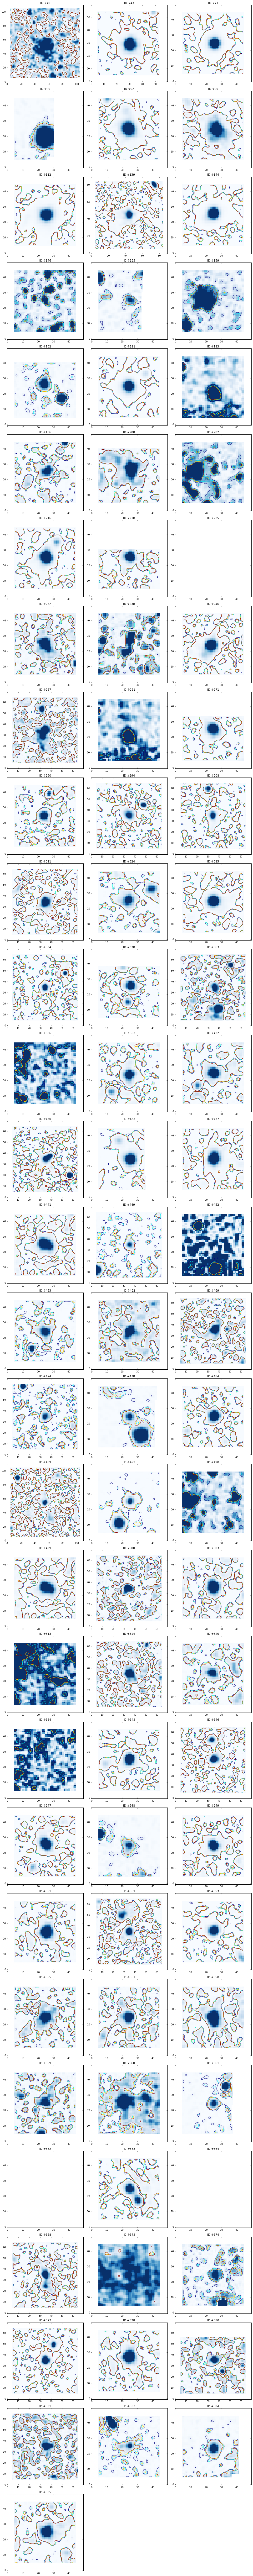

In [92]:
from scipy import ndimage
nb_li = num_src.size / 3 +1
nb_col = 3
plt.figure(figsize=(nb_col*5,nb_li*5))

i=1
num_obj = 1
for num_obj in range(nb_obj):
    

        
    src = src_list[np.where(num_src==num_src_sort[num_obj])[0]]    
    
    if src.id==554:
        continue
    print src.id
    
    # Method parameters
    pfa_faint=0.0001
    pfa_bright=0.01
    diag = 1
    P = 1
    taille_f = 11
    marge = int(taille_f/2)
    beta=2.6
    PFA = np.array([0.1,0.01,0.001, 0.0001])
    median_filtering = True
    
    lam_ang = src.lines['lya_start'][0] +  0.5*(src.lines['lya_end'][0] - src.lines['lya_start'][0])
    fwhm_courant = calcul_fwhm(lam=lam_ang*pas_spectral + lambda_0)
    
    if src.id in (40,489):
        S = 100 + 2*marge
    elif src.id in (139,):
        S = 80 + 2*marge

    elif src.id in (43,):
        S = 50 + 2*marge

    elif src.id in (139,257,294,308,311,334,363,430,449,469,474,489,500,514,546,552,568,577,580,581):
        S = 60+2*marge

    else:
        S = 40 + 2*marge



    W_aff = 300
    
    deb_lar = lam_ang - W_aff/2 * pas_spectral
    pos_ligne = W_aff/2 # en bande
    if deb_lar < lambda_0: 
        deb_lar = lambda_0 +1
        pos_ligne = lam_ang*pas_spectral
        
    fin_lar = deb_lar+W_aff*pas_spectral
    
    sp_range_large = np.arange(deb_lar,fin_lar+1,pas_spectral)
    sub_cube_large = cube.subcube((src.dec,src.ra),S,lbda=(deb_lar,fin_lar),pix=True)
    
    Y_src = np.swapaxes(sub_cube_large.get_np_data(),2,0)
   
    
    ### Median filtering
    if median_filtering==True:
        ss_cube_medfilt = si.medfilt(Y_src,(1,1,301))
        ss_cube_medfilt[np.isnan(ss_cube_medfilt)]=0
        ss_cube_medfilt = ndimage.gaussian_filter(ss_cube_medfilt,sigma=(3,3,1))
        
        Y_ms = Y_src - ss_cube_medfilt
        
    else:
        Y_ms = Y_src
        
    sub_cube_large.data = np.swapaxes(Y_ms,2,0)        

    deb = lam_ang - W/2 * pas_spectral
    pos_ligne = W/2 # en bande
    if deb < lambda_0: 
        deb = lambda_0 +1
        pos_ligne = lam_ang*pas_spectral
        
    fin = deb+(W-1)*pas_spectral

    sub_cube_tight = sub_cube_large.subcube((src.dec,src.ra),S,lbda=(deb,fin),pix=True)
    Y_ms = np.swapaxes(sub_cube_tight.get_np_data(),0,2)
    
    ############
    # Ensuring Y_src cube is "square" (after median filtering + subcube extraction - preserving wcs)
    diff_size = Y_src.shape[0]-Y_src.shape[1]
    if diff_size!=0:
        taille = max( Y_src.shape[0],Y_src.shape[1])
        
        Y_src_new = np.zeros((taille,taille,Y_src.shape[2])) + np.nan
        Y_ms_new = np.zeros((taille,taille,Y_ms.shape[2])) + np.nan
        
        Y_src_new[:Y_src.shape[0],:Y_src.shape[1],:] = Y_src
        Y_ms_new[:Y_src.shape[0],:Y_src.shape[1],:] = Y_ms
        
        Y_src = Y_src_new
        Y_ms = Y_ms_new
    ############ 
    
    #Y_nonan = ma.masked_array(Y_ms, np.tile((np.isnan(Y_ms).any(axis=2))[:,:,np.newaxis], (1,1,W)))
    #sp_mean = ma.mean(ma.mean(Y_nonan, axis=0), axis=0)
    #Y_ms = Y_ms-Y_ms[~np.isnan(Y_ms)].mean()
    #Y_ms = Y_ms - sp_mean[np.newaxis,np.newaxis,:]
    
    centre = np.array([int(S/2),int(S/2)])
    
    params = parameters.Params(Y_ms,centre, pfa_bright=pfa_bright, pfa_faint=pfa_faint, FWHM=fwhm_courant,confident=False)
    
    res, val, ests, X_init, val_init = sd.detection_strategy(params)

    
    
    
    
    beta=2.6
    pas = 0.15
    nb_ech_dic = 50

    taille_f = 11
    marge = int(taille_f/2)

    F = dp.Moffat(taille_f, fwhm_courant,beta)
    D = dp.gen_dic(W, pas = pas, nb_ech=nb_ech_dic,asym=0)
    params.F = F
    params.D = D
    #-------- Moments calculation
    im_ind_est,im_weight_est = mse.get_sparse_estimate(params)
    flux,position,largeur = mse.get_moments(im_ind_est,im_weight_est,D,W,pas,pas_spectral)
    # recasting into original shape (to go inside the latter function)
    flux_new = np.zeros((flux.shape[0]+2*marge, flux.shape[1]+2*marge))+np.nan; 
    position_new = np.copy(flux_new)
    largeur_new = np.copy(flux_new)

    flux_new[marge:-marge,marge:-marge]=flux ; flux = flux_new
    position_new[marge:-marge,marge:-marge]=position ; position = position_new
    largeur_new[marge:-marge,marge:-marge]=largeur ; largeur = largeur_new

    #------- Spectra retrieving ----#

    Y_aff = Y_src
    W_aff = Y_src.shape[2]

    # Initial detection region
    reg_init = ma.masked_array(Y_aff, np.tile(np.invert(X_init)[:,:,np.newaxis], (1,1,W_aff)))
    sp_init = ma.mean(ma.mean(reg_init, axis=0), axis=0)

    # Outer detected region, connex to the center
    ma_ext = morph.binary_propagation(X_init, mask = res) - X_init
    reg_ext = ma.masked_array(Y_aff, np.tile(np.invert(ma_ext)[:,:,np.newaxis], (1,1,W_aff)))
    sp_ext = ma.mean(ma.mean(reg_ext, axis=0), axis=0)

    ma_tout = (res+X_init)>0
    # Outer detected regions, non-connex to the center
    ma_ext_pani = (res*(ma_ext==0)>0)
    reg_ext_pani = ma.masked_array(Y_aff, np.tile(np.invert(ma_ext_pani)[:,:,np.newaxis], (1,1,W_aff)))
    sp_ext_pani = ma.mean(ma.mean(reg_ext_pani, axis=0), axis=0)

    # Outside 
    reg_reste = ma.masked_array(Y_aff, np.tile(ma_ext[:,:,np.newaxis], (1,1,W_aff)))
    reg_reste[np.isnan(reg_reste)]  = 0
    sp_reste = ma.mean(ma.mean(reg_reste, axis=0), axis=0)
    sp_reste_ex = Y_aff[0,0,:] # exemple

    #------------ SNR calculation
    bruit_tab = np.reshape(reg_reste,(reg_reste.shape[0]**2,reg_reste.shape[2]))
    sigma_bruit = np.ma.cov(bruit_tab[~np.isnan(bruit_tab).all(1)],rowvar=0)

    if sp_ext.sum()!=0:
        rsb = 10.*np.log10((np.linalg.norm(sp_ext)**2)/np.trace(sigma_bruit))
    else:
        rsb = -1000


    #--------------------------------------#
    #-------Results retrievings------------#
    #----------(MPDAF Objects)-------------#

    wcs1 = sub_cube_tight.wcs
    waveloc=sub_cube_large.wave

    li = LAMBDA_LINES[src.id]['lambda']     # li = LAMBDA_LINES[src.id]['lambda']        

    # 1) Images (binary + statistics)
    im_wh = sub_cube_large.get_image((sub_cube_large.get_range()[0,0],sub_cube_large.get_range()[1,0]))
    im_nb = sub_cube_large.get_image((li[0],li[1]))

    wcs1 = im_wh.wcs
    im_det_cont = Image(wcs=wcs1, data=val.T)
    im_det = Image(wcs=wcs1, data=(res.T-X_init.T)>0)
    im_det_gal = Image(wcs=wcs1, data=X_init.T)
    im_det_all = Image(wcs=wcs1, data=((res.T+X_init.T)>0))

    # 1b) Moments
    im_flux = Image(wcs=wcs1, data=flux.T)
    im_position = Image(wcs=wcs1, data=position.T)
    im_largeur = Image(wcs=wcs1, data=largeur.T)

    dic_images = {'MUSE_WHITE':im_wh, 'MUSE_NB':im_nb, 'DET_STAT':im_det_cont,'DET_BIN_ALL':im_det_all, 'DET_BIN_HAL':im_det,'DET_BIN_GAL':im_det_gal,'FLUX':im_flux, 'POSITION':im_position, 'FWHM':im_largeur}

    # 2) Detection spectra
    spe_centre = Spectrum(data=sp_init,wave=waveloc)
    spe_ext = Spectrum(data=sp_ext,wave=waveloc)
    spe_ext_pani = Spectrum(data=sp_ext_pani,wave=waveloc)
    spe_reste= Spectrum(data=sp_reste,wave=waveloc)  
    spe_reste_ex= Spectrum(data=sp_reste_ex,wave=waveloc)  

    dic_spectres = {'CENTER':spe_centre, 'PERIPH_ADJ':spe_ext,'PERIPH_NOADJ':spe_ext_pani, 'EXT':spe_reste, 'EXTEX':spe_reste_ex}# 'MUSE_NB':im_nb, 'DET_CONT':im_det_cont, 'DET':im_det}


    objet=Source.from_data(ID=src.id,z=src.z,lines=src.lines,ra=src.ra,dec=src.dec,origin=('HEOLHT', version, 'HDFS-1.24'), images=dic_images, spectra=dic_spectres)
    objet.add_comment(comment='Flux, largeur et position sont indicatifs',author='JBC')
    objet.fwhm_pix= (fwhm_courant,'FWHM_PIX')
    objet.im_size = (S,'IM_SIZE')
    objet.snr_est = (rsb,'SNR_EST')
    objet.im_margin = (marge,'unused margin within detection images')

    objet.write(nom_dossier+'ID'+str(src.id)+'.fits')
    
    
    ###### Some display (illustrative)
    ax = plt.subplot(nb_li,nb_col,num_obj+1)
    val_aff_max = ma.masked_array(val,X_init!=1).min()
    plt.imshow(val.T, origin='lower',vmin=0,vmax=val_aff_max,cmap=plt.cm.Blues,interpolation='nearest')
    
    ksi = st.chi2.isf(PFA, df=X_init.sum())
    plt.contour(val.T, ksi)

    plt.title('ID #'+str(src.id))


    
plt.tight_layout()

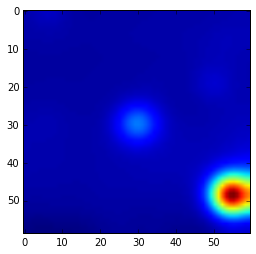

In [26]:
from scipy import ndimage
ss_cube_medfilt[np.isnan(ss_cube_medfilt)]=0
Y_fi = ndimage.gaussian_filter(ss_cube_medfilt,sigma=(3,3,1))
plt.imshow(Y_fi.mean(axis=2))

In [29]:
Y_nonan = ma.masked_array(Y_ms, np.tile((np.isnan(Y_ms).any(axis=2))[:,:,np.newaxis], (1,1,W)))
sp_mean = ma.mean(ma.mean(Y_nonan, axis=0), axis=0)

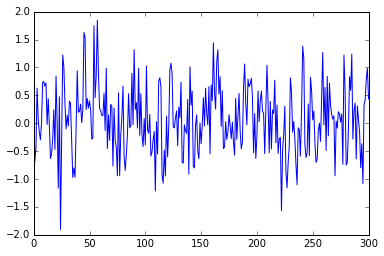

In [52]:
plt.plot(sp_reste_ex)

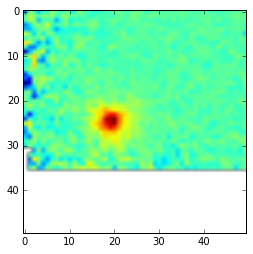

In [30]:
plt.imshow(Y_nonan.mean(axis=2))

In [25]:
Y_ms[~np.isnan(Y_ms)].mean()

4.8213247549455483e-18

In [14]:
src_list = SourceList.from_path(nom_dossier)
#doc_pdf = PdfPages(nom_dossier+'LAE-catalog-HDFS-1.24(safe).pdf')
nb_li = 3
nb_col = 3
num_plot=1
amin = 0
amax=None

taille_f = 11
marge = int(taille_f/2)
beta=2.6
PFA = np.array([0.1,0.01,0.001, 0.0001])

/home/miv/courbot/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:52: RuntimeWarning: invalid value encountered in greater
/home/miv/courbot/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/miv/courbot/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


43


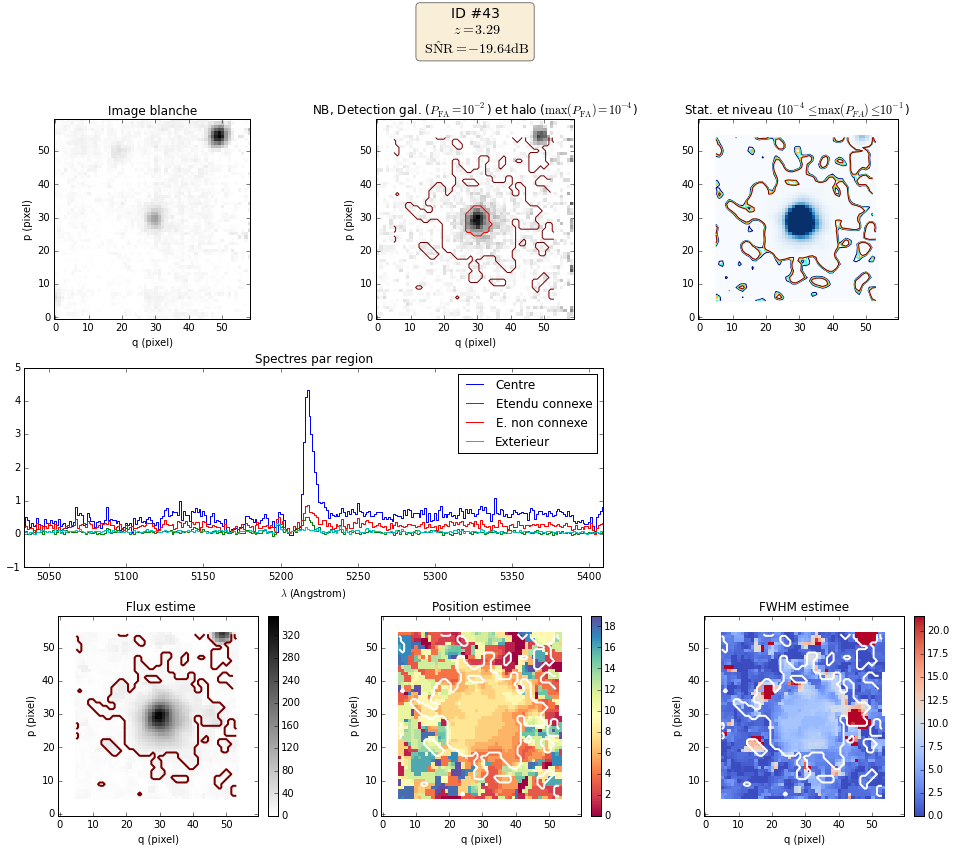

In [15]:
i=1
num_obj = 1
for num_obj in (1,):#range(num_src.size):
    #if num_obj > 1 :
    #    continue
    Fig = plt.figure(figsize=(nb_col*4.5,4*nb_li))
    colmap=plt.cm.Blues
    src = src_list[np.where(num_src==num_src_sort[num_obj])[0]]   
    
    if src.id==554:
        continue
        
    print str(src.id)
    
    val = src.images['DET_STAT'].get_np_data()
    init = src.images['DET_BIN_GAL'].get_np_data()
    res = src.images['DET_BIN_ALL'].get_np_data()

    ksi = st.chi2.isf(PFA, df=init.sum())
    
    flux = src.images['FLUX'].get_np_data()
    position = src.images['POSITION'].get_np_data()
    largeur = src.images['FWHM'].get_np_data()
    
    #plt.contour(val.T, ksi)
    #-------------------------------------#
    #-------- Display   ------------------#
    #-------------------------------------#
    # Text box
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    texte = 'ID #%d \n $z = %.2f$ \n $\\hat{\mathrm{SNR}} =%.2f \mathrm{dB}$ '%(src.id, src.z['lyman'][0], src.snr_est )#' +str(num_lya[obj])+ ' \n z = '+ str(z_lya[obj]) + '\n SNR = '+str(rsb)+'dB'
    plt.suptitle(texte, bbox=props,fontsize=14)

    # 1st image: white image + catalog sources in the projected neighborhood
    ax1 = Fig.add_subplot(nb_li,nb_col, 1)

    ## All sources :
    #plt.scatter(coords[0,:]-xmin, coords[1,:]-ymin, s=75, c='b');
    ## All sources with a close redshift (+/- 0.1)
    #indices = np.abs(coords[2,:] - coords[2,num_lya[obj]])<0.1
    #plt.scatter(coords[0,indices]-xmin, coords[1,indices]-ymin, s=150, c='r');
    src.show_ima(ax1, 'MUSE_WHITE',cuts=(amin, amax))

    plt.axis('on')
    plt.title('Image blanche')
    #plt.xlim([0,S]); plt.ylim([0,S])
    #-------------------------------------#
    # Second image : NB image + detection contours
    ax2 = Fig.add_subplot(nb_li,nb_col, 2)
    src.show_ima(ax2, 'MUSE_NB',cuts=(amin, amax))
    ax2.axis('on')
    res = val > ksi[3]
    if res.sum()>0:
        plt.contour(res, 1,colors='#760000')
    plt.contour((init), 1,colors='r',linestyle='dashed')
    plt.title('NB, Detection gal. ($P_\mathrm{FA}=10^{-2}$) et halo ($\mathrm{max}(P_\mathrm{FA})=10^{-4}$)')

    #-------------------------------------#
    # 3rd image : statistic map and detection contour for various PFA.
    ax3 = Fig.add_subplot(nb_li,nb_col, 3)
    val_aff_max = ma.masked_array(val,init!=1).min()
    plt.imshow(val, origin='lower',vmin=0,vmax=val_aff_max,cmap=colmap,interpolation='nearest')
    plt.contour(val, ksi)
    plt.title('Stat. et niveau ($10^{-4}\\leq \mathrm{max}(P_{FA}) \\leq 10^{-1}$)')
    ax3.axis('on')
    #-------------------------------------#
    # 4th image (second line) : spectra
    ax45 = Fig.add_subplot(nb_li,nb_col, (4,5))
    plt.title('Spectres par region')
    ax45.axis('on')

    
    src.show_spec(ax45, 'CENTER',label='Centre')
    src.show_spec(ax45, 'PERIPH_ADJ',label='Etendu connexe')
    src.show_spec(ax45, 'PERIPH_NOADJ',label='E. non connexe')
    src.show_spec(ax45, 'EXT',label='Exterieur')
    
   
    plt.xlim(src.spectra['CENTER'].get_range())
    plt.legend()
    #-------------------------------------#
    # 5th image : FWHM of the FSF
    #ax6 = Fig.add_subplot(nb_li,nb_col,6)

    #F1 = dp.Moffat(S+1, 0.75*5,beta)
    #plt.imshow(F1, interpolation = 'Nearest',vmin=0, cmap = plt.cm.gray_r,origin='lower') ; 
    #plt.title('FSF et sa FWHM pour $\\lambda_0$') ; 
    #circle1=plt.Circle((int(S/2),int(S/2)),fwhm_courant,color='r',fill=False)
    #ax6.add_artist(circle1)

    #-------- Moments -------------#
    ## Displayed on the 6th, 7th and 8th image, last line.
    ax7 = Fig.add_subplot(nb_li,nb_col, 7)
    detec= (res+init>0)
    detec = detec[marge:S-marge,marge:S-marge]
    plt.xlabel('q (pixel)'); plt.ylabel('p (pixel)')
    plt.imshow(flux,interpolation= 'nearest', vmin = 0, cmap=plt.cm.gray_r,origin='lower')
    plt.title(' Flux estime')
    ax7.axis('on')
    plt.colorbar(fraction=0.046, pad=0.04)
    if detec.sum()!=0:
        plt.contour((res+init>0), 1,linewidths=2,colors='#760000')

    ax8 = Fig.add_subplot(nb_li,nb_col, 8)
    plt.imshow(position, interpolation= 'nearest',cmap=plt.cm.Spectral,origin='lower')
    plt.xlabel('q (pixel)'); plt.ylabel('p (pixel)')
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.title('Position estimee')
    ax8.axis('on')
    if detec.sum()!=0:
        plt.contour((res+init>0), 1,linewidths=2,colors='w')

    ax9 = Fig.add_subplot(nb_li,nb_col, 9)
    
    plt.imshow(largeur, interpolation = 'nearest',cmap=plt.cm.coolwarm,origin='lower')
    plt.xlabel('q (pixel)'); plt.ylabel('p (pixel)')
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.title('FWHM estimee')
    ax9.axis('on')
    plt.tight_layout()
    if detec.sum()!=0:
        plt.contour((res+init>0), 1,linewidths=2,colors='w')

    plt.subplots_adjust(top=0.85)

    num_plot +=1
    #doc_pdf.savefig(Fig)
    #plt.close(Fig)
            
          

#doc_pdf.close()

/home/miv/courbot/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:22: RuntimeWarning: invalid value encountered in greater


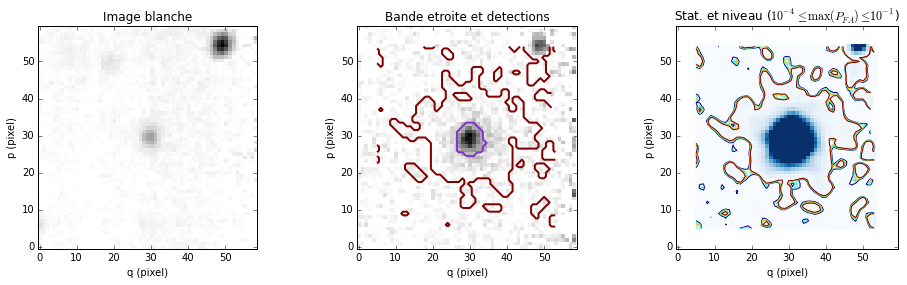

In [16]:
nb_col = 3
nb_li = 1
Fig = plt.figure(figsize=(nb_col*4.5,4*nb_li))

ax1 = Fig.add_subplot(nb_li,nb_col, 1)

## All sources :
#plt.scatter(coords[0,:]-xmin, coords[1,:]-ymin, s=75, c='b');
## All sources with a close redshift (+/- 0.1)
#indices = np.abs(coords[2,:] - coords[2,num_lya[obj]])<0.1
#plt.scatter(coords[0,indices]-xmin, coords[1,indices]-ymin, s=150, c='r');
src.show_ima(ax1, 'MUSE_WHITE',cuts=(amin, amax))

plt.axis('on')
plt.title('Image blanche')
#plt.xlim([0,S]); plt.ylim([0,S])
#-------------------------------------#
# Second image : NB image + detection contours
ax2 = Fig.add_subplot(nb_li,nb_col, 2)
src.show_ima(ax2, 'MUSE_NB',cuts=(amin, amax))
ax2.axis('on')
res = val > ksi[3]
if res.sum()>0:
    plt.contour(res, 1,colors='#800000',linewidths=2)
plt.contour((init), 1,colors='#8234cb',linewidths=2,linestyle='dashed')
plt.title('Bande etroite et detections ')

#-------------------------------------#
# 3rd image : statistic map and detection contour for various PFA.
ax3 = Fig.add_subplot(nb_li,nb_col, 3)
val_aff_max = ma.masked_array(val,init!=1).min()
plt.imshow(val, origin='lower',vmin=0,vmax=val_aff_max/4,cmap=colmap,interpolation='nearest')
plt.contour(val, ksi)
plt.title('Stat. et niveau ($10^{-4}\\leq \mathrm{max}(P_{FA}) \\leq 10^{-1}$)')
ax3.axis('on')
plt.xlabel('q (pixel)')
plt.ylabel('p (pixel)')
plt.tight_layout()
plt.savefig('ex43.eps', format='eps',dpi=100)

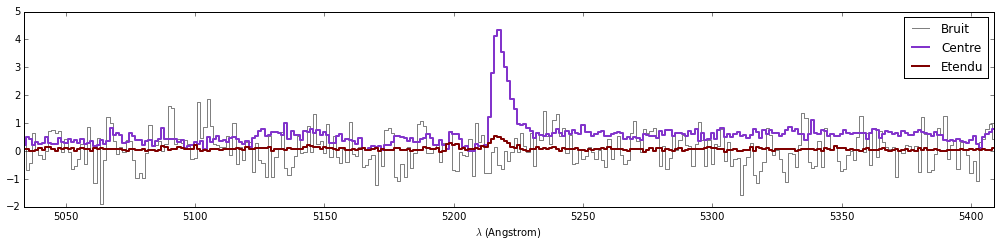

In [17]:
nb_li = 1
nb_col = 4
Fig = plt.figure(figsize=(nb_col*3.5,3.5*nb_li))
ax45 = Fig.add_subplot(nb_li,nb_col, (1,4))
#plt.title('Spectres par region')
ax45.axis('on')

src.show_spec(ax45, 'EXTEX',label='Bruit', color='gray')
src.show_spec(ax45, 'CENTER',label='Centre',linewidth=2,color='#8234cb')
#src.show_spec(ax45, 'EXT',label='Exterieur',linewidth=2)
src.show_spec(ax45, 'PERIPH_ADJ',label='Etendu',linewidth=2, color='#800000')
plt.grid()
plt.legend()
plt.xlim(src.spectra['CENTER'].get_range())



plt.grid()
plt.legend()
plt.tight_layout()

plt.savefig('ex43sp1.eps', format='eps',dpi=100)

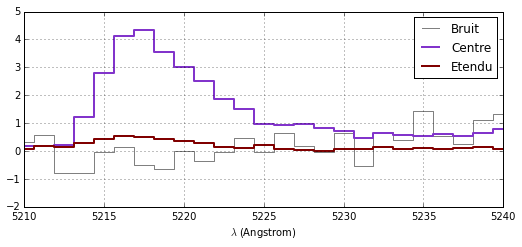

In [18]:
nb_li = 1
nb_col = 4
Fig = plt.figure(figsize=(nb_col*3.5,3.5*nb_li))

ax45 = Fig.add_subplot(nb_li,nb_col, (2,3))
#plt.title('Spectres par region')
ax45.axis('on')

src.show_spec(ax45, 'EXTEX',label='Bruit', color='gray')
src.show_spec(ax45, 'CENTER',label='Centre',linewidth=2,color='#8234cb')
#src.show_spec(ax45, 'EXT',label='Exterieur',linewidth=2)
src.show_spec(ax45, 'PERIPH_ADJ',label='Etendu',linewidth=2, color='#800000')
plt.xlim((5210,5240))



plt.grid()
plt.legend()
plt.tight_layout()

plt.savefig('ex43sp2.eps', format='eps',dpi=100)

In [17]:
nb_li=4
nb_col = 6
plt.figure(figsize=(5*nb_col,5*nb_li))
for num_obj in range(24):
    

    src=src_list[np.where(num_src==num_src_sort[num_obj])[0]]    
    val = src.images['DET_STAT'].get_np_data()
    res = src.images['DET_BIN_ALL'].get_np_data()
    init =src.images['DET_BIN_GAL'].get_np_data()
    ksi = st.chi2.isf(PFA, df=init.sum())
    plt.subplot(nb_li,nb_col,num_obj+1)
    plt.imshow(np.log(1+val),origin='lower',interpolation='nearest',cmap=plt.cm.Blues)
    plt.contour(val,ksi)
    plt.xlim((5,val.shape[0]-1))
    plt.xlim((5,val.shape[1]-1))
    plt.axis('off')

plt.tight_layout()
plt.savefig('resstat.eps', format='eps',dpi=100)

/home/miv/courbot/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


KeyError: 'DET_STAT'

/home/miv/courbot/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


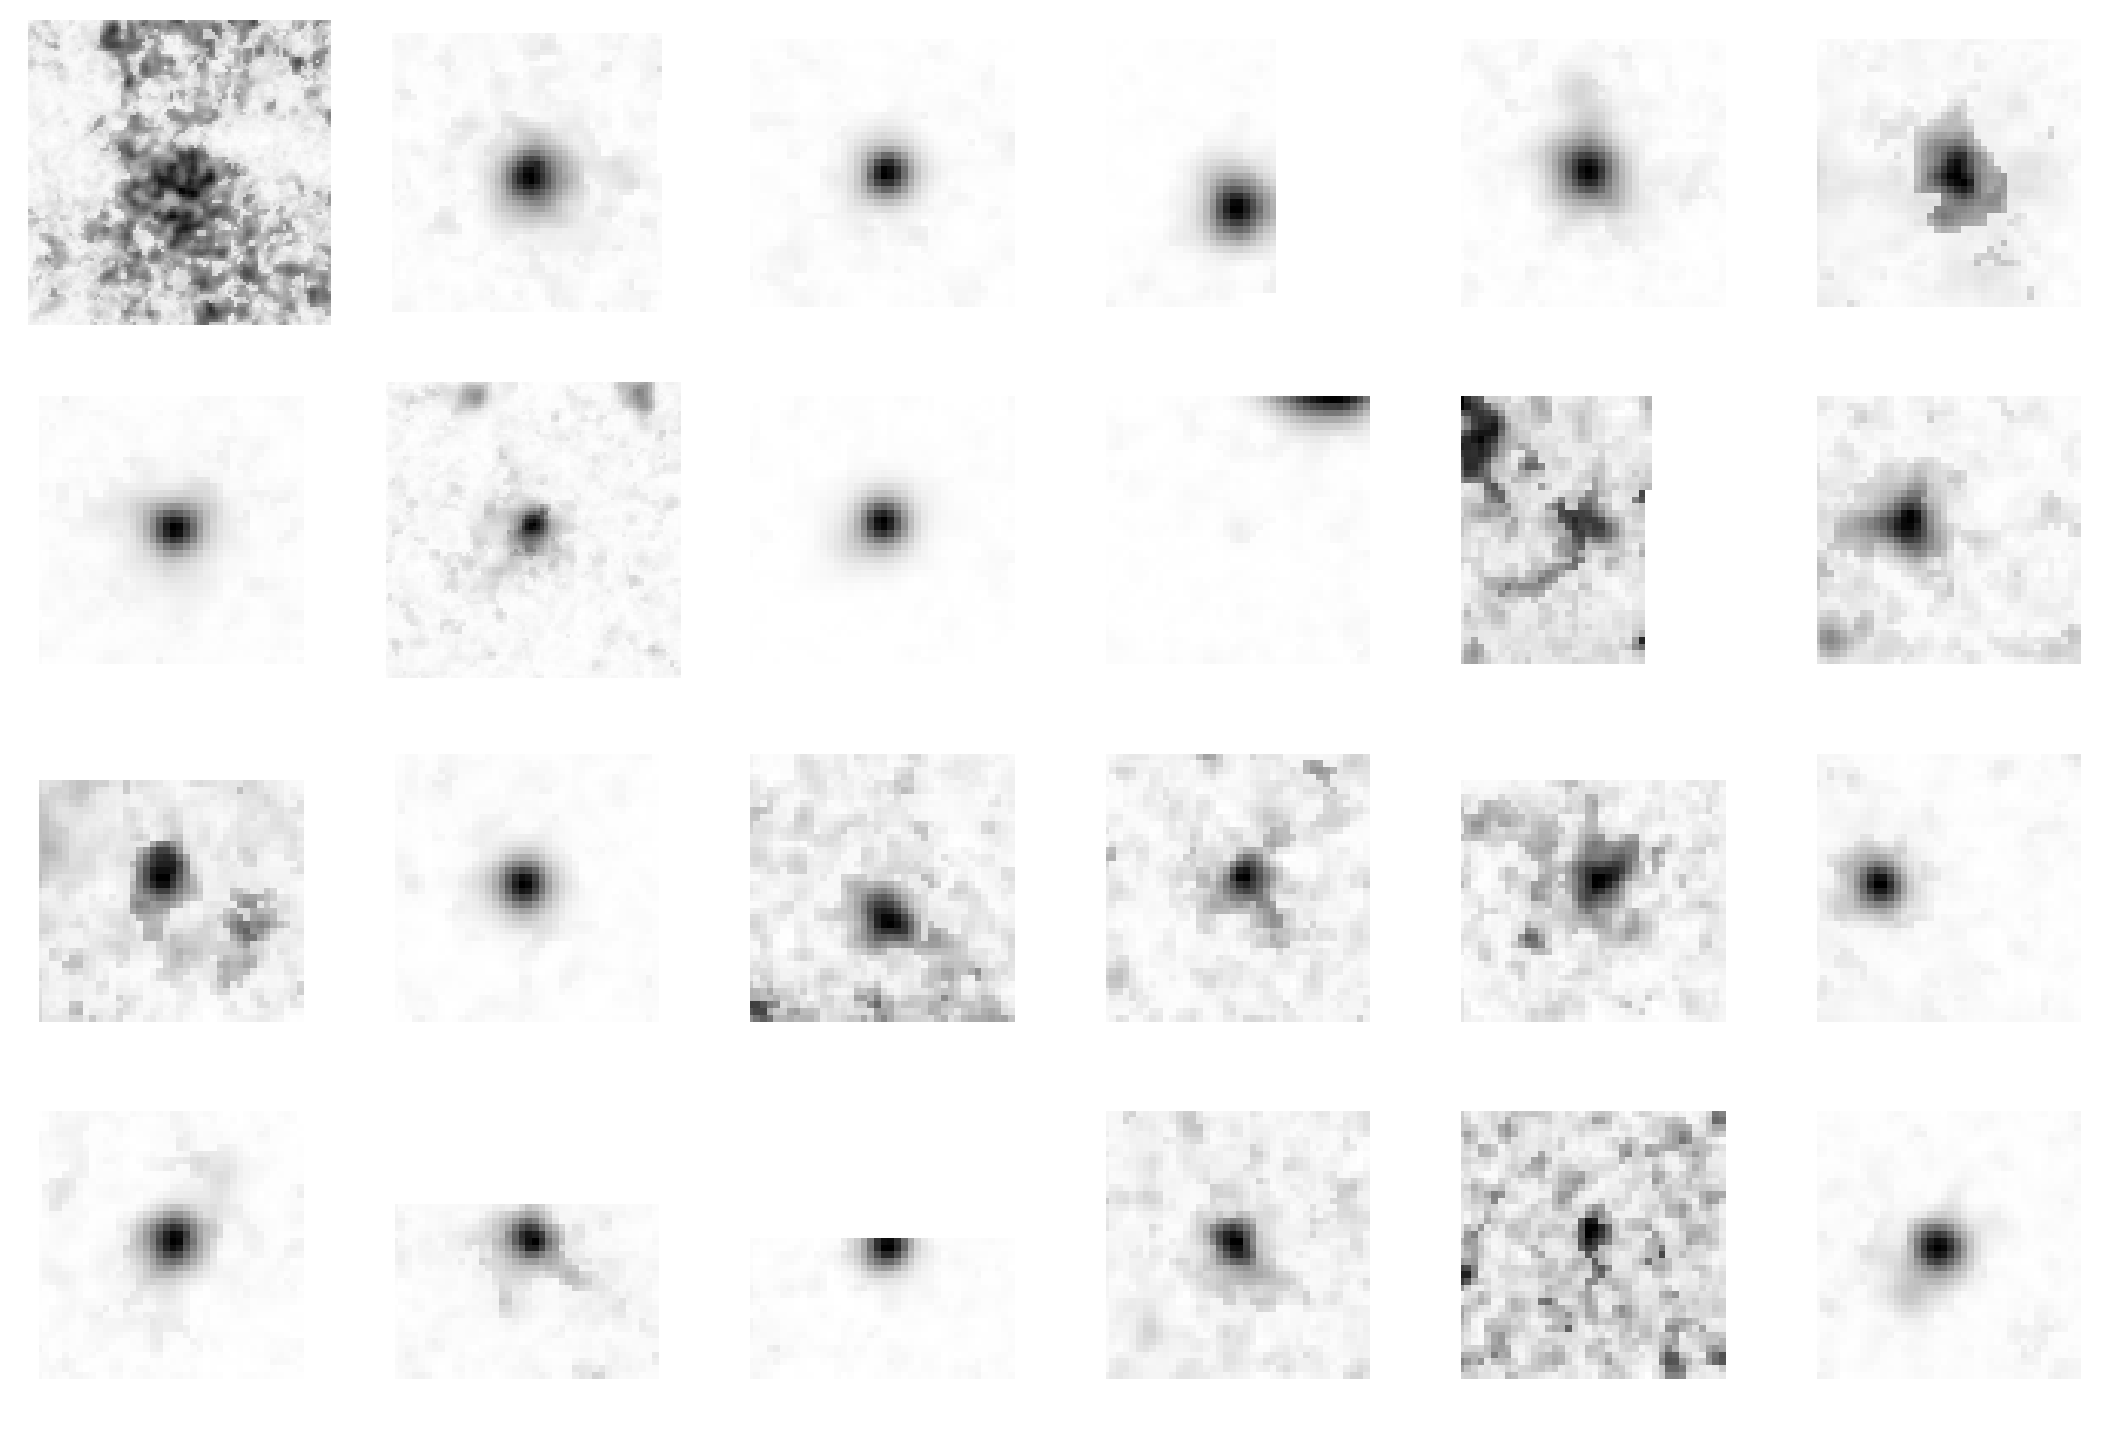

In [41]:
nb_li=4
nb_col = 6
plt.figure(figsize=(5*nb_col,5*nb_li))
for num_obj in range(24):
    

    src=src_list[np.where(num_src==num_src_sort[num_obj])[0]]    

    flux = src.images['FLUX'].get_np_data()
    ksi = st.chi2.isf(PFA, df=init.sum())
    plt.subplot(nb_li,nb_col,num_obj+1)
    plt.imshow(flux,origin='lower',interpolation='nearest',cmap=plt.cm.gray_r)
    plt.xlim((5,val.shape[0]-1))
    plt.xlim((5,val.shape[1]-1))
    plt.axis('off')

plt.tight_layout()
plt.savefig('resflux.eps', format='eps',dpi=100)

/home/miv/courbot/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


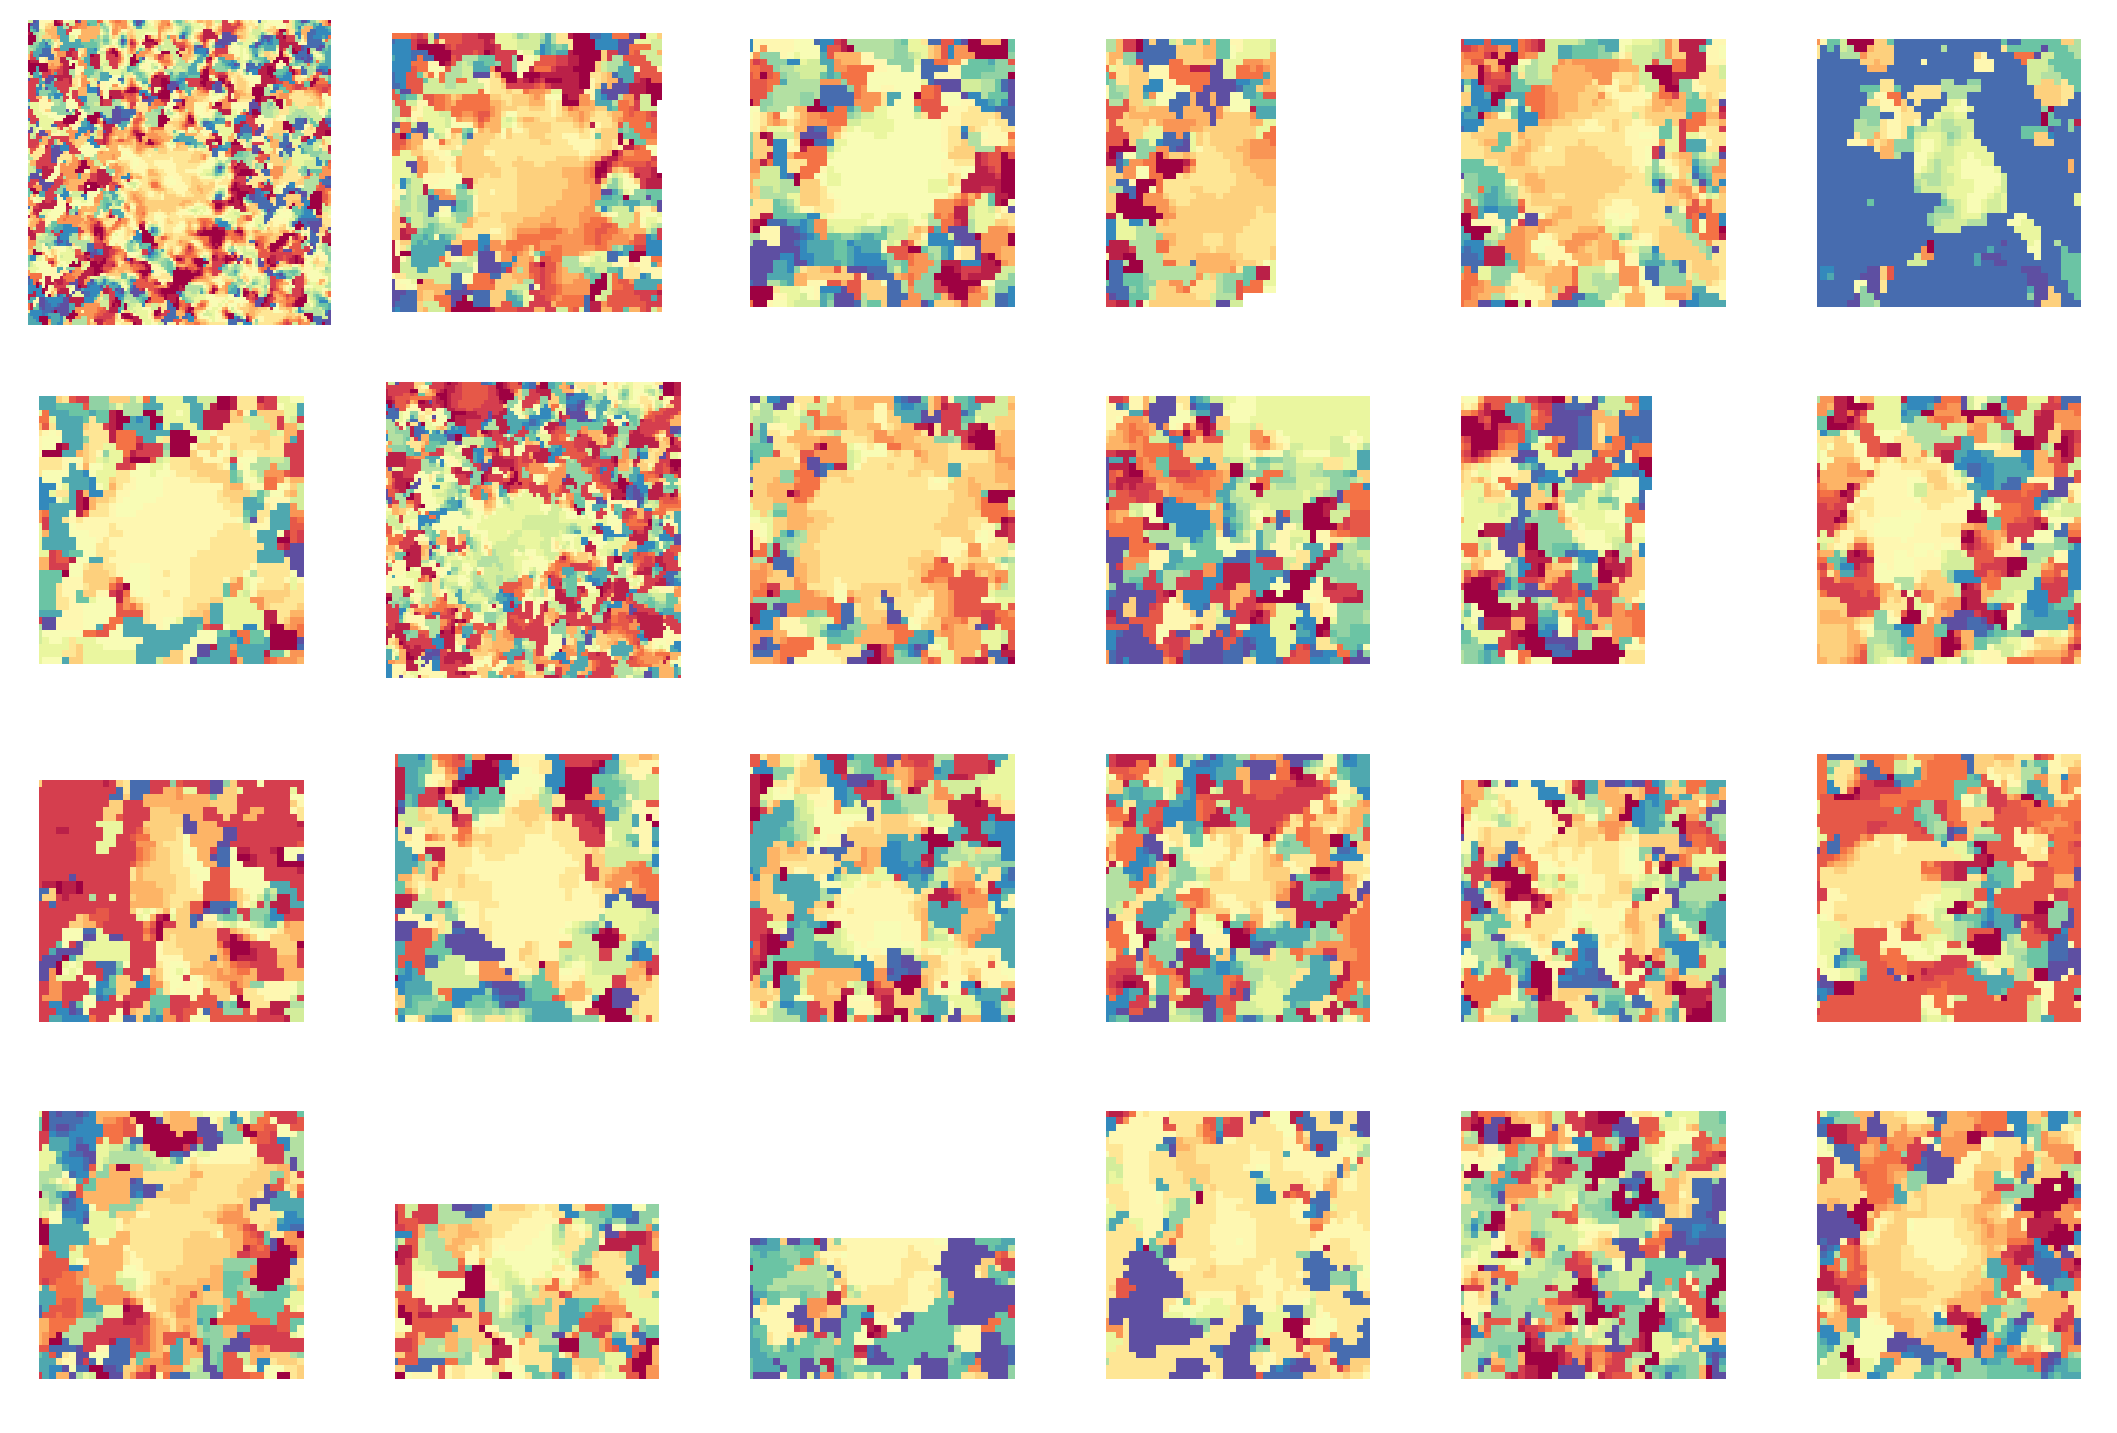

In [48]:
nb_li=4
nb_col = 6
plt.figure(figsize=(5*nb_col,5*nb_li))
for num_obj in range(24):
    

    src=src_list[np.where(num_src==num_src_sort[num_obj])[0]]    

    pos = src.images['POSITION'].get_np_data()

    plt.subplot(nb_li,nb_col,num_obj+1)
    plt.imshow(pos,origin='lower',interpolation='nearest',cmap=plt.cm.Spectral)
    plt.xlim((5,pos.shape[0]-1))
    plt.xlim((5,pos.shape[1]-1))
    plt.axis('off')

plt.tight_layout()
plt.savefig('respos.eps', format='eps',dpi=100)

/home/miv/courbot/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


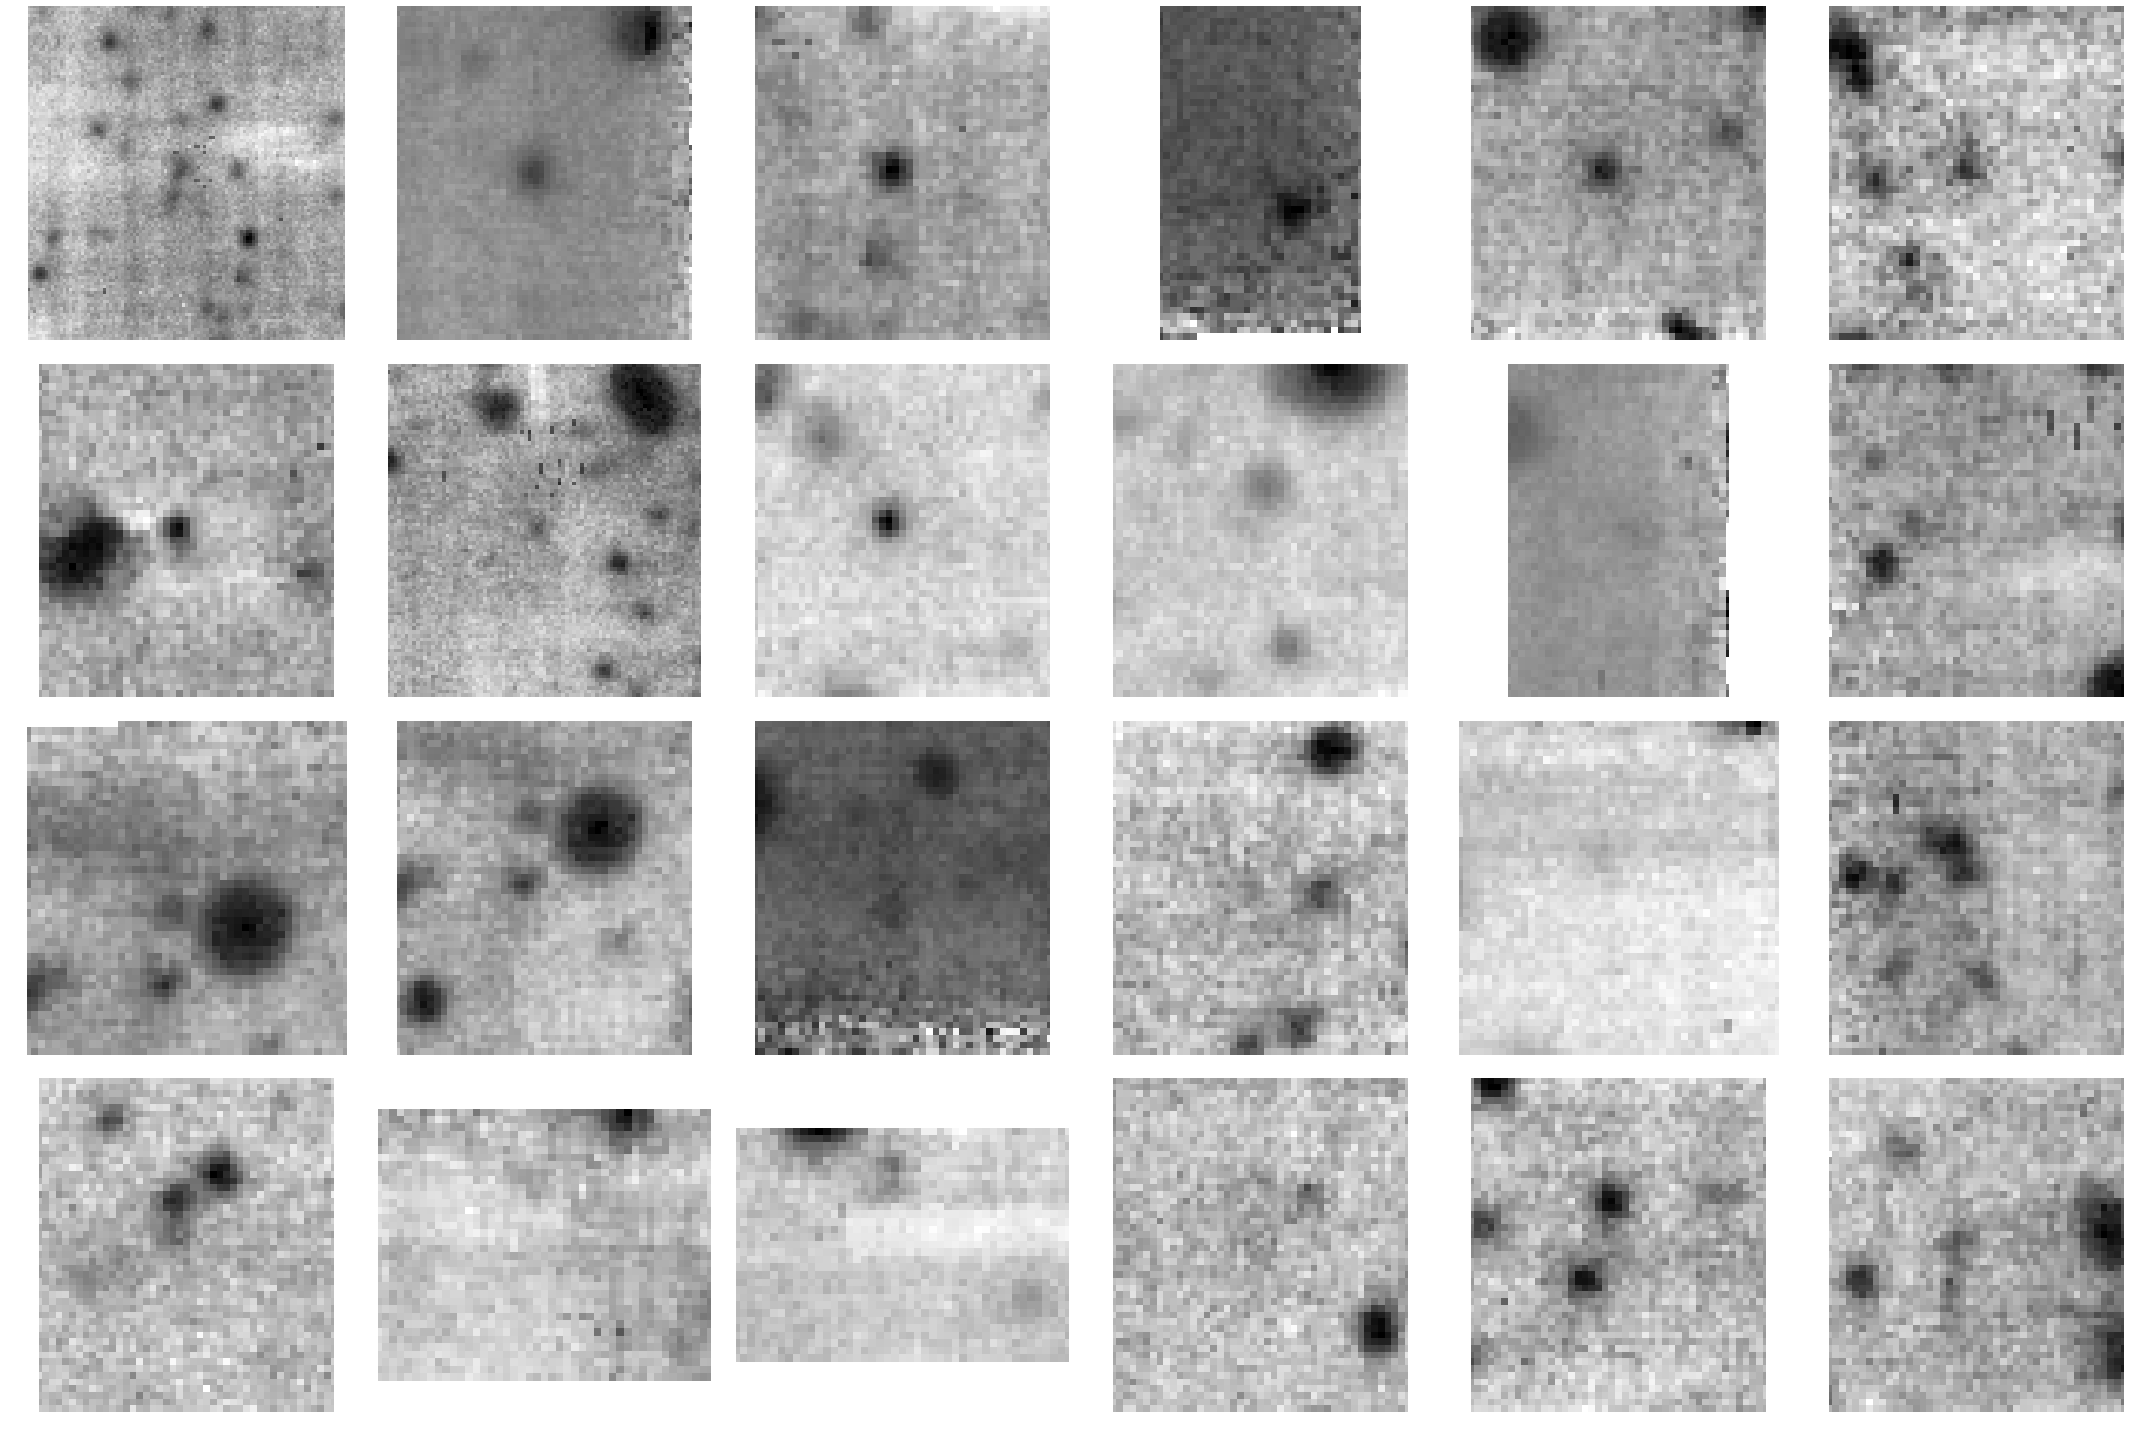

In [46]:
nb_li=4
nb_col = 6
plt.figure(figsize=(5*nb_col,5*nb_li))
for num_obj in range(24):
    

    src=src_list[np.where(num_src==num_src_sort[num_obj])[0]]    
    wh = src.images['MUSE_WHITE'].get_np_data()
    ksi = st.chi2.isf(PFA, df=init.sum())
    plt.subplot(nb_li,nb_col,num_obj+1)
    plt.imshow(wh,origin='lower',interpolation='nearest',cmap=plt.cm.gray_r)
    plt.xlim((5,wh.shape[0]-1))
    plt.xlim((5,wh.shape[1]-1))
    plt.axis('off')

plt.tight_layout()
plt.savefig('reswh.eps', format='eps',dpi=100)